<a href="https://colab.research.google.com/github/JulioLaz/covid19_analytics/blob/main/Copia_de_COVID19_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PROBLEMA DE NEGOCIO
Una entidad gubernamental responsable de la gestión de la salud en un país enfrenta el desafío de comprender y analizar la propagación del COVID-19 para tomar decisiones informadas y eficaces en la gestión de la pandemia. Como científico de datos, tu tarea es analizar los datos relacionados con el COVID-19 y presentar insights a través de visualizaciones que respondan a las siguientes preguntas clave:

**Preguntas**
1. ¿Cómo ha evolucionado el Covid-19 en el país en comparación con el impacto observado a nivel global?

2. ¿Cuál ha sido la evolución de los nuevos casos diarios reportados de Covid-19 en el país a lo largo del tiempo?

3. ¿Cuál es la evolución del índice de letalidad del Covid-19 en el país, comparado con los países con los índices históricos más elevados?

4. Desde una perspectiva demográfica, ¿cuáles son las características que tienen un mayor impacto en el índice de letalidad de un país?

¿Existe otro insight que puedas proporcionar?

# Obtención de datos

In [118]:
# !python -V
# print('------')
# !pip show Pandas | grep 'Name\|Version'
# print('------')
# !pip show Matplotlib | grep 'Name\|Version'

# Python 3.10.12
# ------
# Name: pandas
# Version: 1.5.3
# ------
# Name: matplotlib
# Version: 3.7.1

In [119]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter,MultipleLocator
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [120]:
# df_covid = pd.read_csv(StringIO(requests.get("https://covid19.who.int/WHO-COVID-19-global-data.csv").text))
df_covid = pd.read_csv('/content/drive/MyDrive/COVID/WHO-COVID-19-global-data.csv')

In [121]:
df_covid.columns

Index(['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases',
       'Cumulative_cases', 'New_deaths', 'Cumulative_deaths'],
      dtype='object')

In [122]:
df_population = pd.read_excel('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx', sheet_name=0, skiprows=16)
df_population = df_population[df_population['Year'] == 2019]

In [123]:
# df_population.columns

# Eleccíon de país para el análisis:

In [124]:
pais_x= 'Argentina'

# COVID19: primer insight

In [125]:
df_covid_new = pd.read_csv('/content/drive/MyDrive/COVID/WHO-COVID-19-global-data.csv')
total_cumulative_cases = df_covid_new['Cumulative_cases'].sum()

### Revisar casos acumulatos totales:
print("Total de casos acumulativos:", "{:,.0f}".format(total_cumulative_cases))

Total de casos acumulativos: 80,429,549,713


In [126]:
df=df_covid_new.copy()
columns = ['Cumulative_cases', 'Cumulative_deaths' ]
for col in columns:
  max_cumulative_cases_info_by_country = df.groupby('Country_code')[col].max()
  print(f'Total de {col}:', "{:,.0f}".format(max_cumulative_cases_info_by_country.sum()))

Total de Cumulative_cases: 774,007,977
Total de Cumulative_deaths: 7,011,303


In [127]:
df_covid.groupby('Country')['Cumulative_cases'].max().sum()

774180216

## Nuevo df agrupado por los casos acumulados maxímos y country code:
###**df: max_cumulative_cases_info**

In [128]:
# Encuentra el índice del máximo para cada 'Country_code'
max_cumulative_cases_info_index = df.groupby('Country_code')['Cumulative_cases'].idxmax()

# Selecciona las filas correspondientes al índice del máximo
max_cumulative_cases_info = df.loc[max_cumulative_cases_info_index]

# Seleccion de columns
columns=['Date_reported','Country_code','Country','New_cases','Cumulative_cases','New_deaths','Cumulative_deaths']
max_cumulative_cases_info=max_cumulative_cases_info[columns]

max_cumulative_cases_info = max_cumulative_cases_info.dropna(subset=['Country_code'])
max_cumulative_cases_info.fillna(0, inplace=True)

max_cumulative_cases_info.reset_index(drop=True, inplace=True)
max_cumulative_cases_info['lethality_rate']=(max_cumulative_cases_info['Cumulative_deaths']/max_cumulative_cases_info['Cumulative_cases']*100).round(2)

### Convertir a int64
max_cumulative_cases_info['New_cases'] = pd.to_numeric(max_cumulative_cases_info['New_cases'], errors='coerce').astype('Int64')
max_cumulative_cases_info['New_deaths'] = pd.to_numeric(max_cumulative_cases_info['New_deaths'], errors='coerce').astype('Int64')

### Ordenar
max_cumulative_cases_info = max_cumulative_cases_info.sort_values(by='Cumulative_cases', ascending=False)

max_cumulative_cases_info.describe().round(2)
# max_cumulative_cases_info[['Cumulative_cases', 'Cumulative_deaths',	'lethality_rate']].describe().round(2)

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
count,233.0,2.330000e+02,233.0,233.00,231.00
mean,1997.66,3.321923e+06,15.03,29933.79,1.23
std,11111.93,1.143660e+07,129.28,104350.00,1.56
min,0.0,0.000000e+00,0.0,0.00,0.00
25%,6.0,2.529200e+04,0.0,172.00,0.39
50%,32.0,1.914960e+05,0.0,1536.00,0.83
75%,399.0,1.278512e+06,2.0,14122.00,1.64
max,135331.0,1.034368e+08,1943.0,1127152.00,18.07


In [129]:
max_cumulative_cases_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 215 to 110
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      233 non-null    object 
 1   Country_code       233 non-null    object 
 2   Country            233 non-null    object 
 3   New_cases          233 non-null    Int64  
 4   Cumulative_cases   233 non-null    int64  
 5   New_deaths         233 non-null    Int64  
 6   Cumulative_deaths  233 non-null    int64  
 7   lethality_rate     231 non-null    float64
dtypes: Int64(2), float64(1), int64(2), object(3)
memory usage: 16.8+ KB


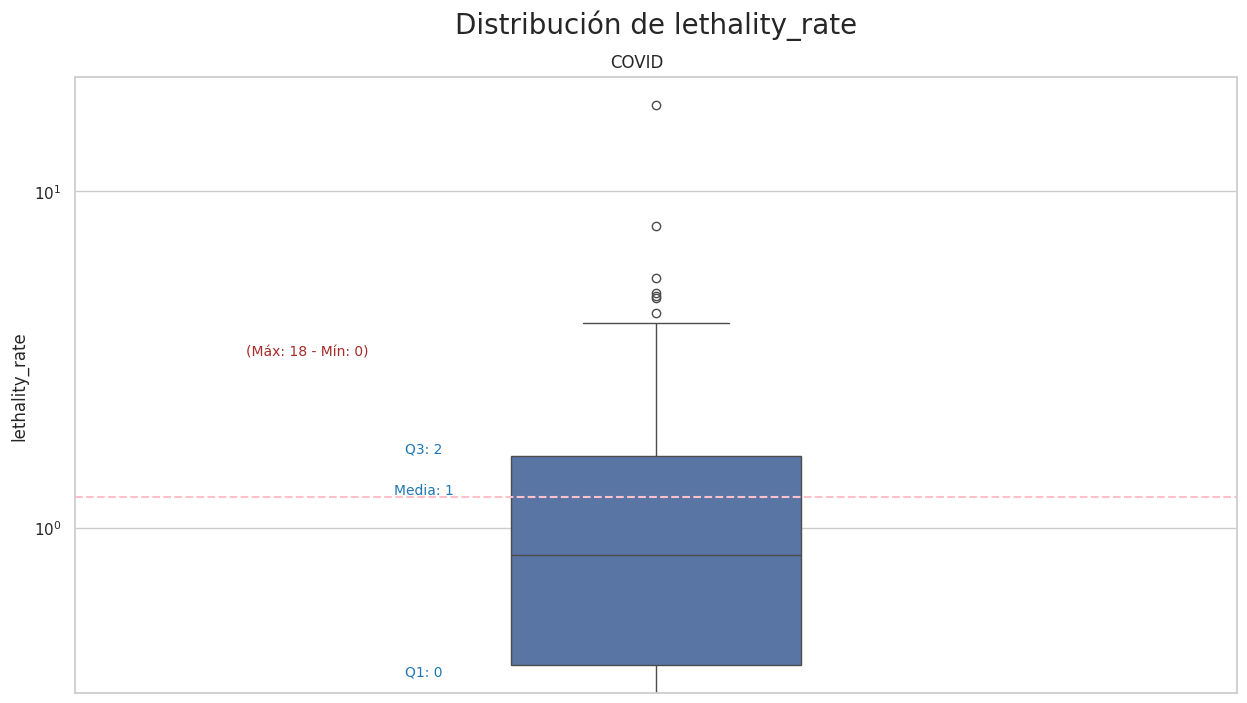

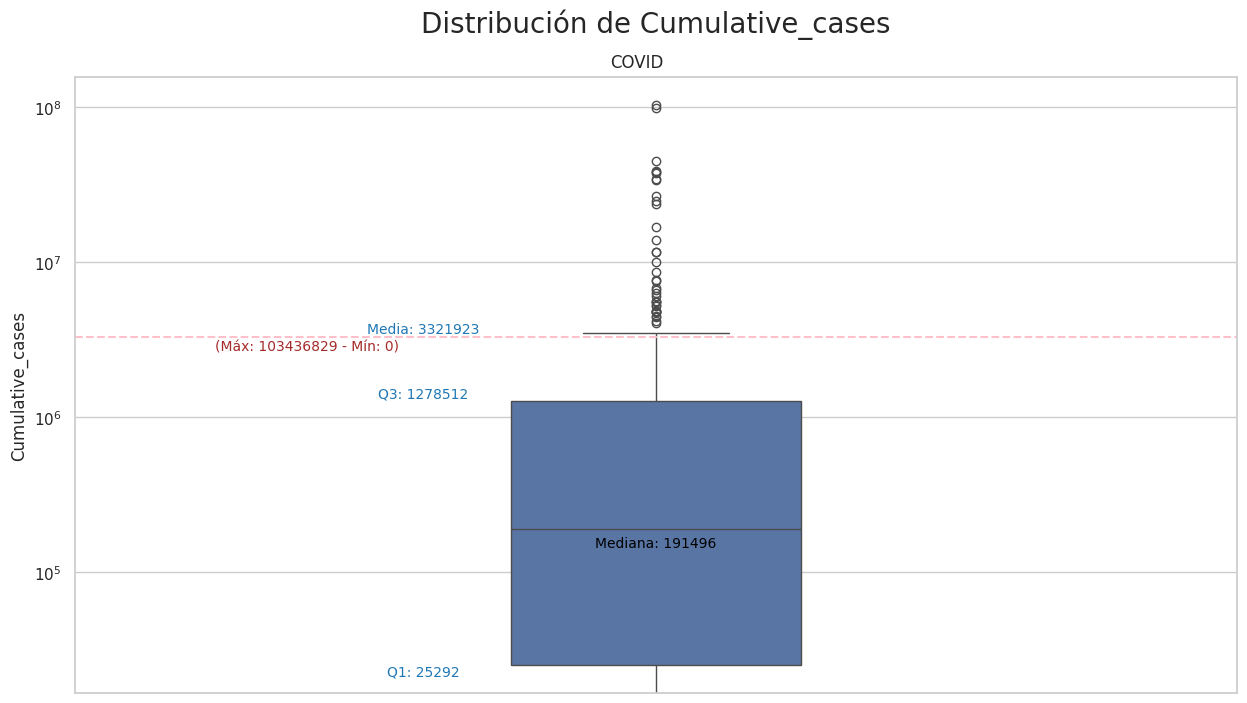

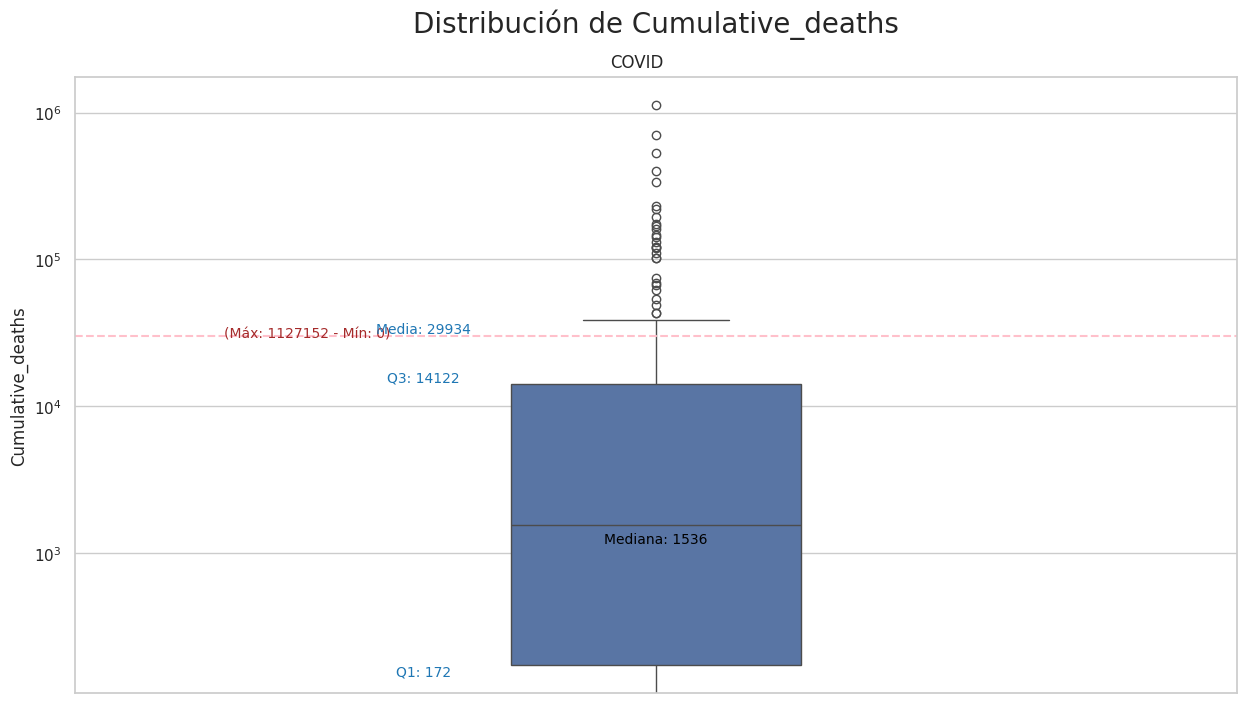

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_new = max_cumulative_cases_info
columnas = ['lethality_rate', 'Cumulative_cases', 'Cumulative_deaths']

for columna in columnas:
    sns.set(style="whitegrid", rc={"figure.figsize": (15, 8)})

    cuartiles = [0, 0.25, 0.5, 0.75, 1]
    valores = df_new[columna].quantile(cuartiles)
    colores = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

    sns.boxplot(y=columna, data=df_new, orient='v', palette=colores, whis=2, width=0.25)

    # Configura el eje y en escala logarítmica
    plt.yscale("log")

    # Línea marcando el promedio:
    plt.axhline(y=df_new[columna].mean(), linestyle='--', color='#FFC0CB')

    # Calcular los valores de los bigotes
    iqr = valores[0.75] - valores[0.25]
    bigote_sup = min(valores[1], valores[0.75] + 1.5 * iqr)
    bigote_inf = max(valores[0], valores[0.25] - 1.5 * iqr)

    # Coloco valores en el gráfico:
    plt.text(-0.3, bigote_sup, f'(Máx: {valores[1]:.0f} - Mín: {valores[0]:.0f})', fontsize=10, ha='center', va='top', color='brown')

    plt.text(-0.2, valores[0.25], f'Q1: {valores[0.25]:.0f}', fontsize=10, ha='center', va='top', color='#1f77b4')
    plt.text(-0.2, valores[0.75], f'Q3: {valores[0.75]:.0f}', fontsize=10, ha='center', va='bottom', color='#1f77b4')
    plt.text(-0.2, df_new[columna].mean(), f'Media: {df_new[columna].mean():.0f}', fontsize=10, ha='center', va='bottom', color='#1f77b4')

    # Calcular la mediana para colocar el valor en el gráfico
    mediana = np.median(df_new[columna])
    plt.text(0, mediana*0.9, f'Mediana: {mediana:.0f}', fontsize=10, ha='center', va='top', color='black')

    plt.title(f'Distribución de {columna}', fontsize=20, pad=32)
    plt.suptitle('COVID', fontsize=12, y=0.91)

    plt.show()


In [131]:
df=max_cumulative_cases_info
columns = ['Cumulative_cases', 'Cumulative_deaths']

for col in columns:
  max_cumulative_cases_info_by_country = df.groupby('Country_code')[col].max()
  print(f'Total de {col}:', "{:,.0f}".format(max_cumulative_cases_info_by_country.sum()))

Total de Cumulative_cases: 774,007,977
Total de Cumulative_deaths: 6,974,574


###REvisión de últimas fechas reportadas:

In [132]:
df=df_covid_new.copy()

# Convierte 'Date_reported' a tipo datetime para asegurar un orden correcto
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

# Encuentra el índice de la última fecha para cada 'Country_code'
last_date_index = df.groupby('Country_code')['Date_reported'].idxmax()

# Selecciona las filas correspondientes al índice de la última fecha
last_date_info = df.loc[last_date_index]

# Crea un nuevo DataFrame con la información de la última fecha
new_df_last_date = pd.DataFrame(last_date_info)
new_df_last_date =new_df_last_date.reset_index(drop=True)
new_df_last_date

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2024-01-14,AD,Andorra,EURO,NaN,48015,NaN,159
1,2024-01-14,AE,United Arab Emirates,EMRO,NaN,1067030,NaN,2349
2,2024-01-14,AF,Afghanistan,EMRO,203.0,230826,2.0,7975
3,2024-01-14,AG,Antigua and Barbuda,AMRO,NaN,9106,NaN,146
4,2024-01-14,AI,Anguilla,AMRO,NaN,3904,NaN,12
...,...,...,...,...,...,...,...,...
228,2024-01-14,YE,Yemen,EMRO,NaN,11945,NaN,2159
229,2024-01-14,YT,Mayotte,NaN,NaN,42027,NaN,187
230,2024-01-14,ZA,South Africa,AFRO,NaN,4072540,NaN,102595
231,2024-01-14,ZM,Zambia,AFRO,NaN,349289,NaN,4069


In [133]:
df=new_df_last_date
for col in columns:
  max_cumulative_cases_info_by_country = df.groupby('Country_code')[col].max()
  print(f'Total de {col}:', "{:,.0f}".format(max_cumulative_cases_info_by_country.sum()))

Total de Cumulative_cases: 773,972,132
Total de Cumulative_deaths: 7,009,036


# TRATAMIENTO DE DATOS DE COVID19 --->  df_covid_limpio
---

In [134]:
columns=['Date_reported','Country_code','Country','New_cases','Cumulative_cases','New_deaths','Cumulative_deaths']
df_covid=df_covid[columns]
df_covid.head()

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-05,AF,Afghanistan,NaN,0,NaN,0
1,2020-01-12,AF,Afghanistan,NaN,0,NaN,0
2,2020-01-19,AF,Afghanistan,NaN,0,NaN,0
3,2020-01-26,AF,Afghanistan,NaN,0,NaN,0
4,2020-02-02,AF,Afghanistan,NaN,0,NaN,0


In [135]:
###   ELIMINO FILAS NULAS DE LAS COLUMNA Country_code   ###
# df_covid.Country_code.dropna(inplace=True)
df_covid = df_covid.dropna(subset=['Country_code'])


In [136]:
### REEMPLAZO LOS NULL POR 0   ###
df_covid.fillna(0, inplace=True)
df_covid.head()

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-05,AF,Afghanistan,0.0,0,0.0,0
1,2020-01-12,AF,Afghanistan,0.0,0,0.0,0
2,2020-01-19,AF,Afghanistan,0.0,0,0.0,0
3,2020-01-26,AF,Afghanistan,0.0,0,0.0,0
4,2020-02-02,AF,Afghanistan,0.0,0,0.0,0


In [137]:
### Convierte la columna 'Date_reported' al formato datetime64[ns]  ###
df_covid['Date_reported'] = pd.to_datetime(df_covid['Date_reported'])
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49163 entries, 0 to 50639
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      49163 non-null  datetime64[ns]
 1   Country_code       49163 non-null  object        
 2   Country            49163 non-null  object        
 3   New_cases          49163 non-null  float64       
 4   Cumulative_cases   49163 non-null  int64         
 5   New_deaths         49163 non-null  float64       
 6   Cumulative_deaths  49163 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 3.0+ MB


In [138]:
df_covid.sample(5)

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
16725,2021-01-31,GA,Gabon,470.0,10748,1.0,68
28556,2021-05-16,MH,Marshall Islands,0.0,4,0.0,0
26034,2021-07-25,LS,Lesotho,482.0,12880,24.0,363
38548,2022-10-23,BL,Saint Barthélemy,10.0,5323,0.0,5
33669,2022-04-24,MK,North Macedonia,590.0,309107,7.0,9629


In [139]:
### Convierte las columnas 'New_cases' y 'New_deaths' al formato int64   ###
df_covid['New_cases'] = pd.to_numeric(df_covid['New_cases'], errors='coerce').astype('Int64')
df_covid['New_deaths'] = pd.to_numeric(df_covid['New_deaths'], errors='coerce').astype('Int64')
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49163 entries, 0 to 50639
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      49163 non-null  datetime64[ns]
 1   Country_code       49163 non-null  object        
 2   Country            49163 non-null  object        
 3   New_cases          49163 non-null  Int64         
 4   Cumulative_cases   49163 non-null  int64         
 5   New_deaths         49163 non-null  Int64         
 6   Cumulative_deaths  49163 non-null  int64         
dtypes: Int64(2), datetime64[ns](1), int64(2), object(2)
memory usage: 3.1+ MB


In [140]:
# Adiciono nueva columna: indice de letalidad:
df_covid['lethality_rate']=df_covid['Cumulative_deaths']/df_covid['Cumulative_cases']*100
df_covid.sample(1)

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
18716,2022-11-06,GP,Guadeloupe,455,196725,0,993,0.504766


In [141]:
### REEMPLAZO LOS NULL POR 0   ###
df_covid['lethality_rate'].fillna(0, inplace=True)
df_covid.sample(1)

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
11089,2022-04-03,CU,Cuba,5491,1091852,3,8512,0.779593


In [142]:
df_covid['lethality_rate'].sample(5)

28506     0.000000
24509     0.000000
10886     1.406319
27866     0.000000
6137     14.285714
Name: lethality_rate, dtype: float64

In [143]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49163 entries, 0 to 50639
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      49163 non-null  datetime64[ns]
 1   Country_code       49163 non-null  object        
 2   Country            49163 non-null  object        
 3   New_cases          49163 non-null  Int64         
 4   Cumulative_cases   49163 non-null  int64         
 5   New_deaths         49163 non-null  Int64         
 6   Cumulative_deaths  49163 non-null  int64         
 7   lethality_rate     49163 non-null  float64       
dtypes: Int64(2), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.5+ MB


In [144]:
### Calcular los cuantiles 0 y 0.99 de la columna 'lethality_rate'
q0 = df_covid['lethality_rate'].quantile(0)
q99 = df_covid['lethality_rate'].quantile(0.99)

# Filtra los registros que se encuentran entre los cuantiles 0 y 0.99
df_covid_limpio = df_covid[(df_covid['lethality_rate'] >= q0) & (df_covid['lethality_rate'] <= q99)]
df_covid_limpio

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
0,2020-01-05,AF,Afghanistan,0,0,0,0,0.000000
1,2020-01-12,AF,Afghanistan,0,0,0,0,0.000000
2,2020-01-19,AF,Afghanistan,0,0,0,0,0.000000
3,2020-01-26,AF,Afghanistan,0,0,0,0,0.000000
4,2020-02-02,AF,Afghanistan,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...
50635,2023-12-17,ZW,Zimbabwe,50,266025,0,5730,2.153933
50636,2023-12-24,ZW,Zimbabwe,23,266048,1,5731,2.154123
50637,2023-12-31,ZW,Zimbabwe,-119,265929,-7,5724,2.152454
50638,2024-01-07,ZW,Zimbabwe,46,265975,3,5727,2.153210


In [145]:
# Cambio de nombres a columnas:
replacements = {
    "United States of America": "USA",
    "United Kingdom of Great Britain and Northern Ireland": "U. Kingdom",
    "Republic of Korea": "Korea"
}
df_covid_limpio.replace(replacements,inplace=True)
df_covid_limpio

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
0,2020-01-05,AF,Afghanistan,0,0,0,0,0.000000
1,2020-01-12,AF,Afghanistan,0,0,0,0,0.000000
2,2020-01-19,AF,Afghanistan,0,0,0,0,0.000000
3,2020-01-26,AF,Afghanistan,0,0,0,0,0.000000
4,2020-02-02,AF,Afghanistan,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...
50635,2023-12-17,ZW,Zimbabwe,50,266025,0,5730,2.153933
50636,2023-12-24,ZW,Zimbabwe,23,266048,1,5731,2.154123
50637,2023-12-31,ZW,Zimbabwe,-119,265929,-7,5724,2.152454
50638,2024-01-07,ZW,Zimbabwe,46,265975,3,5727,2.153210


In [146]:
df_covid_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48671 entries, 0 to 50639
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      48671 non-null  datetime64[ns]
 1   Country_code       48671 non-null  object        
 2   Country            48671 non-null  object        
 3   New_cases          48671 non-null  Int64         
 4   Cumulative_cases   48671 non-null  int64         
 5   New_deaths         48671 non-null  Int64         
 6   Cumulative_deaths  48671 non-null  int64         
 7   lethality_rate     48671 non-null  float64       
dtypes: Int64(2), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.4+ MB


In [147]:
df_covid_limpio.columns

Index(['Date_reported', 'Country_code', 'Country', 'New_cases',
       'Cumulative_cases', 'New_deaths', 'Cumulative_deaths',
       'lethality_rate'],
      dtype='object')

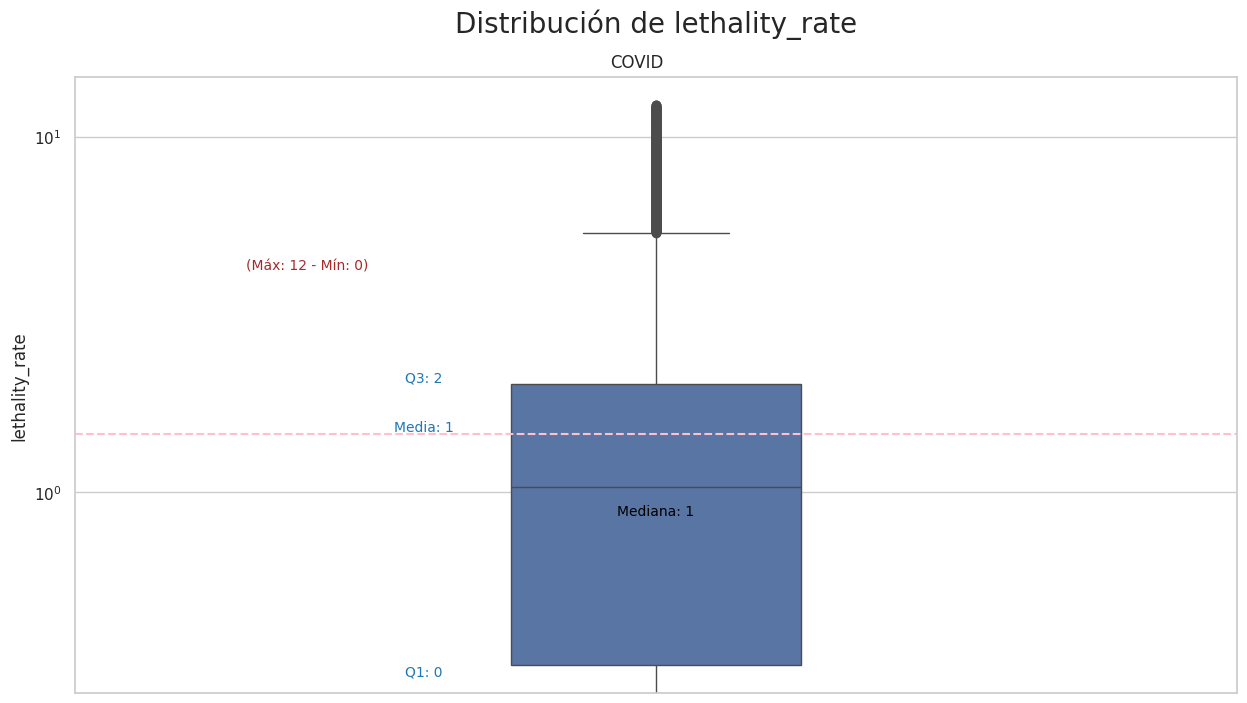

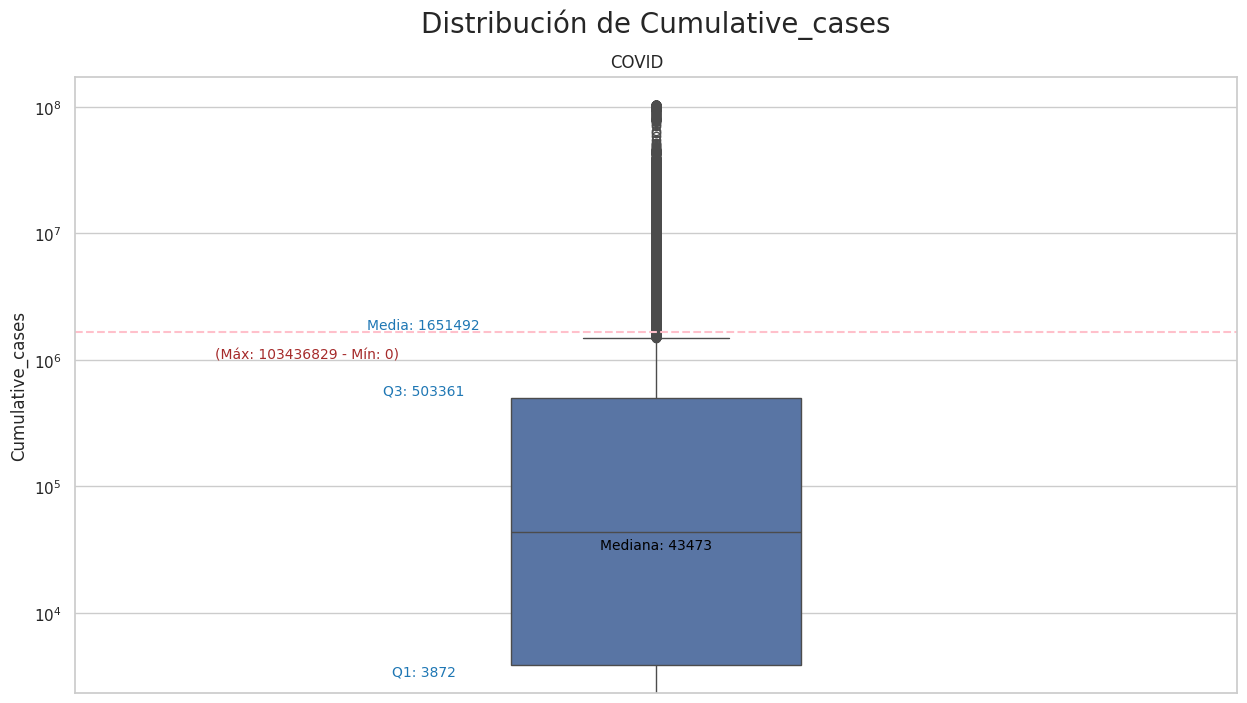

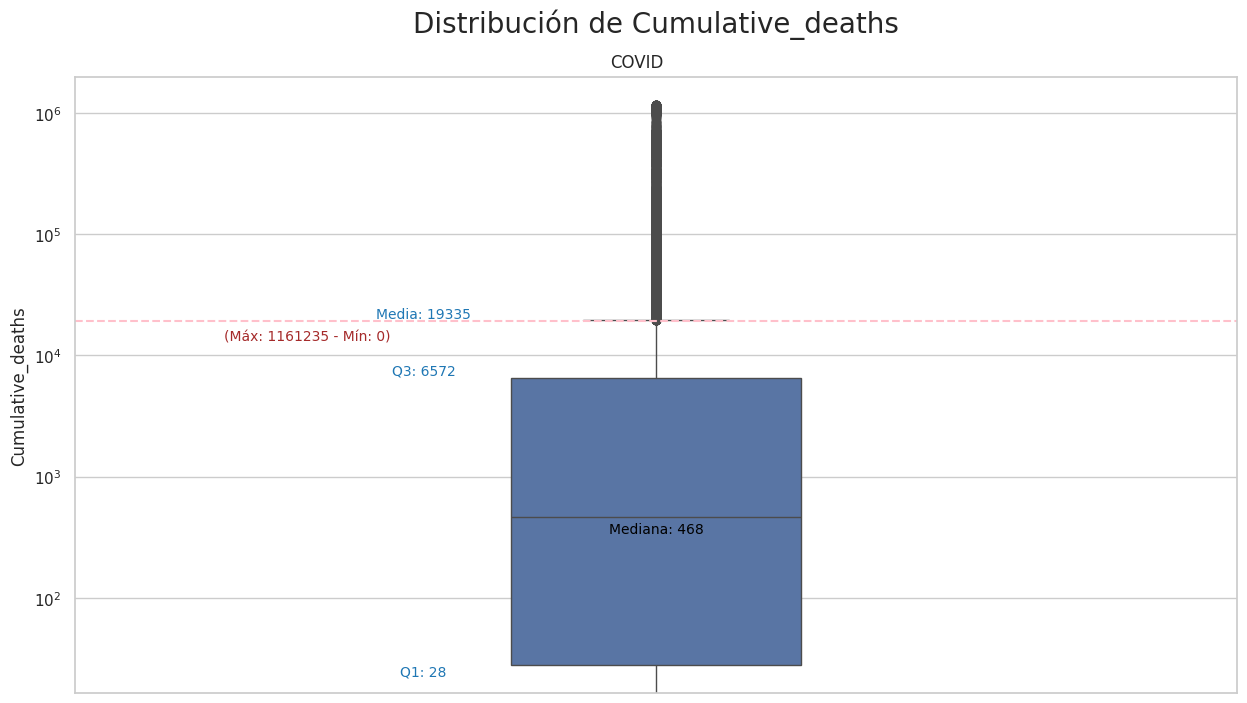

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_new = df_covid_limpio
columnas = ['lethality_rate', 'Cumulative_cases', 'Cumulative_deaths']

for columna in columnas:
    sns.set(style="whitegrid", rc={"figure.figsize": (15, 8)})

    cuartiles = [0, 0.25, 0.5, 0.75, 1]
    valores = df_new[columna].quantile(cuartiles)
    colores = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

    sns.boxplot(y=columna, data=df_new, orient='v', palette=colores, whis=2, width=0.25)

    # Configura el eje y en escala logarítmica
    plt.yscale("log")

    # Línea marcando el promedio:
    plt.axhline(y=df_new[columna].mean(), linestyle='--', color='#FFC0CB')

    # Calcular los valores de los bigotes
    iqr = valores[0.75] - valores[0.25]
    bigote_sup = min(valores[1], valores[0.75] + 1.5 * iqr)
    bigote_inf = max(valores[0], valores[0.25] - 1.5 * iqr)

    # Coloco valores en el gráfico:
    plt.text(-0.3, bigote_sup, f'(Máx: {valores[1]:.0f} - Mín: {valores[0]:.0f})', fontsize=10, ha='center', va='top', color='brown')

    plt.text(-0.2, valores[0.25], f'Q1: {valores[0.25]:.0f}', fontsize=10, ha='center', va='top', color='#1f77b4')
    plt.text(-0.2, valores[0.75], f'Q3: {valores[0.75]:.0f}', fontsize=10, ha='center', va='bottom', color='#1f77b4')
    plt.text(-0.2, df_new[columna].mean(), f'Media: {df_new[columna].mean():.0f}', fontsize=10, ha='center', va='bottom', color='#1f77b4')

    # Calcular la mediana para colocar el valor en el gráfico
    mediana = np.median(df_new[columna])
    plt.text(0, mediana*0.9, f'Mediana: {mediana:.0f}', fontsize=10, ha='center', va='top', color='black')

    plt.title(f'Distribución de {columna}', fontsize=20, pad=32)
    plt.suptitle('COVID', fontsize=12, y=0.91)

    plt.show()


In [149]:
df_covid_limpio.describe().round(2)

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
count,48671.0,4.867100e+04,48671.0,48671.00,48671.00
mean,15859.97,1.651492e+06,138.53,19334.98,1.45
std,242609.24,7.282898e+06,869.23,79316.71,1.63
min,-65079.0,0.000000e+00,-3432.0,0.00,0.00
25%,0.0,3.872000e+03,0.0,28.00,0.33
50%,104.0,4.347300e+04,0.0,468.00,1.03
75%,2024.5,5.033610e+05,20.0,6572.00,2.01
max,40475477.0,1.034368e+08,47687.0,1161235.00,12.27


In [150]:
df_covid_limpio = df_covid_limpio[df_covid_limpio['New_cases'] >= 0]
df_covid_limpio = df_covid_limpio[df_covid_limpio['New_deaths'] >= 0]
df_covid_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48629 entries, 0 to 50639
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      48629 non-null  datetime64[ns]
 1   Country_code       48629 non-null  object        
 2   Country            48629 non-null  object        
 3   New_cases          48629 non-null  Int64         
 4   Cumulative_cases   48629 non-null  int64         
 5   New_deaths         48629 non-null  Int64         
 6   Cumulative_deaths  48629 non-null  int64         
 7   lethality_rate     48629 non-null  float64       
dtypes: Int64(2), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.4+ MB


In [151]:
df_covid_limpio.describe()

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
count,48629.0,4.862900e+04,48629.0,4.862900e+04,48629.000000
mean,15874.119723,1.652241e+06,138.641387,1.934425e+04,1.454626
std,242713.292391,7.285735e+06,869.249621,7.934797e+04,1.628717
min,0.0,0.000000e+00,0.0,0.000000e+00,0.000000
25%,0.0,3.866000e+03,0.0,2.800000e+01,0.325331
50%,104.0,4.342300e+04,0.0,4.680000e+02,1.029184
75%,2028.0,5.044910e+05,20.0,6.582000e+03,2.006118
max,40475477.0,1.034368e+08,47687.0,1.161235e+06,12.267776


# TRATAMIENTO DE DATOS DE POBLACIÓN  ---> df_population_limpio

In [152]:
###selección de columnas:
columns_pop=['ISO2 Alpha-code','Total Population, as of 1 July (thousands)','Male Population, as of 1 July (thousands)','Female Population, as of 1 July (thousands)','Population Density, as of 1 July (persons per square km)','Life Expectancy at Birth, both sexes (years)','Population Sex Ratio, as of 1 July (males per 100 females)','Median Age, as of 1 July (years)','Life Expectancy at Age 15, both sexes (years)','Life Expectancy at Age 65, both sexes (years)','Life Expectancy at Age 80, both sexes (years)']
df_population=df_population[columns_pop]
df_population

,ISO2 Alpha-code,"Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Life Expectancy at Birth, both sexes (years)","Population Sex Ratio, as of 1 July (males per 100 females)","Median Age, as of 1 July (years)","Life Expectancy at Age 15, both sexes (years)","Life Expectancy at Age 65, both sexes (years)","Life Expectancy at Age 80, both sexes (years)"
69,NaN,7764951.032,3906407.855,3858543.178,59.546,72.79,101.24,29.469,61.257,17.459,8.361
142,NaN,1080677.346,538158.386,542518.959,49.425,60.725,99.196,17.42,52.152,13.39,6.175
214,NaN,530149.56,273104.233,257045.327,42.485,73.392,106.247,25.267,60.67,15.75,6.952
286,NaN,2021559.651,1033583.865,987975.786,195.683,70.615,104.616,25.901,58.794,15.386,7.365
358,NaN,2324282.002,1176368.32,1147913.681,143.117,77.013,102.479,35.37,63.398,18.008,8.412
...,...,...,...,...,...,...,...,...,...,...,...
20305,WS,211.905,108.147,103.759,74.878,72.157,104.229,20.412,58.859,14.879,6.575
20377,TK,1.752,0.879,0.874,146,75.076,100.572,26.398,60.727,16.501,7.36
20449,TO,104.951,51.994,52.956,161.462,70.871,98.182,21.259,56.977,14.773,6.707
20521,TV,10.956,5.654,5.301,365.2,64.278,106.658,24.729,51.229,12.777,5.942


In [153]:
df_population.rename(columns={
    'ISO2 Alpha-code': 'Country_code',
    'Total Population, as of 1 July (thousands)': 'Total_Population',
    'Male Population, as of 1 July (thousands)': 'Male_Population',
    'Female Population, as of 1 July (thousands)': 'Female_Population',
    'Population Density, as of 1 July (persons per square km)': 'Population_Density',
    'Life Expectancy at Birth, both sexes (years)': 'Life_Expectancy_0',
    'Life Expectancy at Age 15, both sexes (years)':'Life_Expectancy_15',
    'Life Expectancy at Age 65, both sexes (years)':'Life_Expectancy_65',
    'Life Expectancy at Age 80, both sexes (years)':'Life_Expectancy_80',
    'Population Sex Ratio, as of 1 July (males per 100 females)':'Population_Sex_Ratio',
    'Median Age, as of 1 July (years)':'Median_Age'
},inplace=True)
#'Population_Sex_Ratio''Median_Age'
df_population.reset_index(drop=True, inplace=True)
df_population

,Country_code,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy_0,Population_Sex_Ratio,Median_Age,Life_Expectancy_15,Life_Expectancy_65,Life_Expectancy_80
0,NaN,7764951.032,3906407.855,3858543.178,59.546,72.79,101.24,29.469,61.257,17.459,8.361
1,NaN,1080677.346,538158.386,542518.959,49.425,60.725,99.196,17.42,52.152,13.39,6.175
2,NaN,530149.56,273104.233,257045.327,42.485,73.392,106.247,25.267,60.67,15.75,6.952
3,NaN,2021559.651,1033583.865,987975.786,195.683,70.615,104.616,25.901,58.794,15.386,7.365
4,NaN,2324282.002,1176368.32,1147913.681,143.117,77.013,102.479,35.37,63.398,18.008,8.412
...,...,...,...,...,...,...,...,...,...,...,...
281,WS,211.905,108.147,103.759,74.878,72.157,104.229,20.412,58.859,14.879,6.575
282,TK,1.752,0.879,0.874,146,75.076,100.572,26.398,60.727,16.501,7.36
283,TO,104.951,51.994,52.956,161.462,70.871,98.182,21.259,56.977,14.773,6.707
284,TV,10.956,5.654,5.301,365.2,64.278,106.658,24.729,51.229,12.777,5.942


In [154]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Country_code          236 non-null    object
 1   Total_Population      286 non-null    object
 2   Male_Population       286 non-null    object
 3   Female_Population     286 non-null    object
 4   Population_Density    286 non-null    object
 5   Life_Expectancy_0     286 non-null    object
 6   Population_Sex_Ratio  286 non-null    object
 7   Median_Age            286 non-null    object
 8   Life_Expectancy_15    286 non-null    object
 9   Life_Expectancy_65    286 non-null    object
 10  Life_Expectancy_80    286 non-null    object
dtypes: object(11)
memory usage: 24.7+ KB


In [155]:
###   ELIMINO FILAS NULAS DE LAS COLUMNA Country_code   ###
df_population.dropna(subset=['Country_code'],inplace=True)

In [156]:
df_population.Country_code.info()

<class 'pandas.core.series.Series'>
Int64Index: 236 entries, 24 to 285
Series name: Country_code
Non-Null Count  Dtype 
--------------  ----- 
236 non-null    object
dtypes: object(1)
memory usage: 3.7+ KB


In [157]:
df_population.columns

Index(['Country_code', 'Total_Population', 'Male_Population',
       'Female_Population', 'Population_Density', 'Life_Expectancy_0',
       'Population_Sex_Ratio', 'Median_Age', 'Life_Expectancy_15',
       'Life_Expectancy_65', 'Life_Expectancy_80'],
      dtype='object')

In [158]:
# Convertir valores numéricos de las columnas:
columns_to_convert = ['Total_Population', 'Male_Population', 'Female_Population', 'Population_Density','Population_Sex_Ratio','Median_Age','Life_Expectancy_0','Life_Expectancy_15','Life_Expectancy_65','Life_Expectancy_80' ]
for column in columns_to_convert:
    df_population[column] = pd.to_numeric(df_population[column], errors='coerce')

In [159]:
df_population.dtypes

Country_code             object
Total_Population        float64
Male_Population         float64
Female_Population       float64
Population_Density      float64
Life_Expectancy_0       float64
Population_Sex_Ratio    float64
Median_Age              float64
Life_Expectancy_15      float64
Life_Expectancy_65      float64
Life_Expectancy_80      float64
dtype: object

In [160]:
### REEMPLAZO LOS NULL POR 0   ###
df_population.fillna(0, inplace=True)
df_population.head()

,Country_code,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy_0,Population_Sex_Ratio,Median_Age,Life_Expectancy_15,Life_Expectancy_65,Life_Expectancy_80
24,BI,11874.838,5894.278,5980.560,457.605,62.351,98.557,15.308,52.758,13.453,5.824
25,KM,790.986,397.126,393.860,425.033,64.068,100.829,19.613,53.974,12.606,5.439
26,DJ,1073.994,533.626,540.367,46.333,63.085,98.753,23.235,53.471,13.639,5.889
27,ER,3498.818,1724.860,1773.958,28.881,67.300,97.232,17.781,56.143,14.505,6.264
28,ET,114120.594,57375.433,56745.161,114.121,65.838,101.111,18.072,55.471,14.295,6.169


In [161]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 24 to 285
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country_code          236 non-null    object 
 1   Total_Population      236 non-null    float64
 2   Male_Population       236 non-null    float64
 3   Female_Population     236 non-null    float64
 4   Population_Density    236 non-null    float64
 5   Life_Expectancy_0     236 non-null    float64
 6   Population_Sex_Ratio  236 non-null    float64
 7   Median_Age            236 non-null    float64
 8   Life_Expectancy_15    236 non-null    float64
 9   Life_Expectancy_65    236 non-null    float64
 10  Life_Expectancy_80    236 non-null    float64
dtypes: float64(10), object(1)
memory usage: 22.1+ KB


In [162]:
# corregir info:
list_col_x_1000=['Total_Population','Male_Population','Female_Population']
for column in list_col_x_1000:
    df_population[column] = (df_population[column] * 1000).astype(int)

In [163]:
len(df_population)

236

In [164]:
### Verificar nulos
nulos_totales = df_population.isnull().sum()
print("Valores nulos en el DataFrame:")
print(nulos_totales)

Valores nulos en el DataFrame:
Country_code            0
Total_Population        0
Male_Population         0
Female_Population       0
Population_Density      0
Life_Expectancy_0       0
Population_Sex_Ratio    0
Median_Age              0
Life_Expectancy_15      0
Life_Expectancy_65      0
Life_Expectancy_80      0
dtype: int64


In [165]:
### Copiar el df y resetear el index

df_population_limpio = df_population.reset_index(drop=True)
df_population_limpio.head(5)

,Country_code,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy_0,Population_Sex_Ratio,Median_Age,Life_Expectancy_15,Life_Expectancy_65,Life_Expectancy_80
0,BI,11874838,5894278,5980560,457.605,62.351,98.557,15.308,52.758,13.453,5.824
1,KM,790986,397126,393860,425.033,64.068,100.829,19.613,53.974,12.606,5.439
2,DJ,1073994,533626,540367,46.333,63.085,98.753,23.235,53.471,13.639,5.889
3,ER,3498818,1724860,1773958,28.881,67.300,97.232,17.781,56.143,14.505,6.264
4,ET,114120594,57375433,56745161,114.121,65.838,101.111,18.072,55.471,14.295,6.169


# NEW DATAFRAME: uniendo max_cumulative_cases_info con df_population_limpio --->   **df_covid_and_population**

## Uniendo tablas:

In [166]:
df1=max_cumulative_cases_info[['Country_code','Country','Cumulative_cases', 'Cumulative_deaths',	'lethality_rate']]
df2=df_population_limpio
df_covid_and_population = pd.merge(df1, df2, on='Country_code', how='inner')
df_covid_and_population.sort_values(by='Cumulative_cases', ascending=False, inplace=True)

### Creo nueva columna: relación entre población total y numero de muertos por covid19

In [167]:
### creo columna de la relacion poblacion/muertes
df_covid_and_population['pop_death_rate']=df_covid_and_population['Cumulative_deaths']*100/df_covid_and_population['Total_Population']
df_covid_and_population.sort_values(by='pop_death_rate',ascending=False,inplace=True)

### ELIMINO FILAS CON VALOR 0 EN Cumulative_cases and Cumulative_deaths
df_covid_and_population = df_covid_and_population.query('Cumulative_cases != 0 and Cumulative_deaths != 0')
df_covid_and_population.reset_index(drop=True, inplace=True)

df_covid_and_population

,Country_code,Country,Cumulative_cases,Cumulative_deaths,lethality_rate,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy_0,Population_Sex_Ratio,Median_Age,Life_Expectancy_15,Life_Expectancy_65,Life_Expectancy_80,pop_death_rate
0,PE,Peru,4536733,221583,4.88,32824860,16268182,16556679,25.643,76.156,98.258,27.694,62.449,17.437,7.035,0.675046
1,BG,Bulgaria,1325067,38650,2.92,7052532,3420914,3631617,65.063,75.062,94.198,43.919,60.674,16.231,7.121,0.548030
2,HU,Hungary,2228206,48976,2.20,9771796,4678593,5093203,107.940,76.454,91.860,42.121,61.870,16.880,7.844,0.501198
3,BA,Bosnia and Herzegovina,403508,16380,4.06,3360711,1652504,1708207,65.643,77.241,96.739,41.149,62.735,15.764,6.967,0.487397
4,MK,North Macedonia,350244,9963,2.84,2114176,1054637,1059539,84.862,77.293,99.537,37.611,62.899,15.905,6.782,0.471247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,NE,Niger,9515,315,3.31,23443393,11889761,11553632,18.507,62.897,102.909,14.429,54.267,12.756,4.888,0.001344
221,TJ,Tajikistan,17786,125,0.70,9337003,4696898,4640105,65.248,70.867,101.224,21.221,58.442,14.157,6.136,0.001339
222,BJ,Benin,28036,163,0.58,12290444,6152125,6138319,108.996,60.454,100.225,17.357,52.932,13.469,5.820,0.001326
223,TD,Chad,7698,194,2.52,16126866,8094822,8032044,12.807,53.259,100.782,14.898,47.896,12.034,5.203,0.001203


In [168]:
#Top 10
top_10_paises = df_covid_and_population.nlargest(10, 'pop_death_rate')
top_10_paises.sort_values(by='Cumulative_deaths',ascending=False,inplace=True)
top_10_paises.reset_index(drop=True,inplace=True)

In [169]:
top_10_paises[['Country','Cumulative_deaths','Total_Population']]

,Country,Cumulative_deaths,Total_Population
0,Peru,221583,32824860
1,Hungary,48976,9771796
2,Czechia,43411,10536871
3,Bulgaria,38650,7052532
4,Croatia,18687,4129752
5,Georgia,17132,3770811
6,Bosnia and Herzegovina,16380,3360711
7,North Macedonia,9963,2114176
8,Slovenia,9837,2112901
9,Montenegro,2654,630396


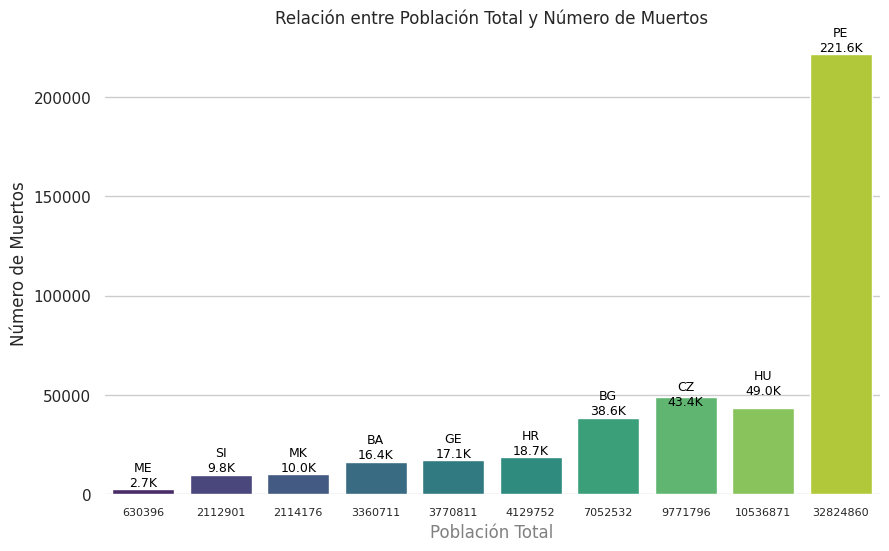

In [170]:
# Crea el gráfico de barras
top_10_paises.sort_values(by='Cumulative_deaths',ascending=False,inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Population', y='Cumulative_deaths', data=top_10_paises, palette='viridis')

plt.xlabel('Población Total', color='gray')
plt.ylabel('Número de Muertos')
plt.title('Relación entre Población Total y Número de Muertos')
plt.xticks(fontsize=8)

top_10_paises.sort_values(by='Cumulative_deaths',ascending=True,inplace=True)

for i, (total_population, cumulative_deaths, country_code) in enumerate(zip(top_10_paises['Total_Population'], top_10_paises['Cumulative_deaths'], top_10_paises['Country_code'])):
    plt.text(i, cumulative_deaths, f'{country_code}\n{cumulative_deaths/1000:.1f}K', ha='center', va='bottom', fontsize=9, color='black')
plt.box(None)
plt.show()


In [171]:
top_10_paises

,Country_code,Country,Cumulative_cases,Cumulative_deaths,lethality_rate,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy_0,Population_Sex_Ratio,Median_Age,Life_Expectancy_15,Life_Expectancy_65,Life_Expectancy_80,pop_death_rate
9,ME,Montenegro,251280,2654,1.06,630396,307383,323013,45.641,77.040,95.161,37.680,62.338,16.482,7.571,0.421005
8,SI,Slovenia,1354807,9837,0.73,2112901,1058072,1054830,104.921,81.604,100.307,42.641,66.842,19.510,9.204,0.465568
7,MK,North Macedonia,350244,9963,2.84,2114176,1054637,1059539,84.862,77.293,99.537,37.611,62.899,15.905,6.782,0.471247
6,BA,Bosnia and Herzegovina,403508,16380,4.06,3360711,1652504,1708207,65.643,77.241,96.739,41.149,62.735,15.764,6.967,0.487397
5,GE,Georgia,1855289,17132,0.92,3770811,1774749,1996062,54.264,73.470,88.913,36.202,59.237,15.043,6.546,0.454332
4,HR,Croatia,1309728,18687,1.43,4129752,2007499,2122252,73.883,78.738,94.593,43.262,64.145,17.396,7.854,0.452497
3,BG,Bulgaria,1325067,38650,2.92,7052532,3420914,3631617,65.063,75.062,94.198,43.919,60.674,16.231,7.121,0.548030
2,CZ,Czechia,4750980,43411,0.91,10536871,5189271,5347600,136.483,79.243,97.039,41.880,64.556,18.279,8.284,0.411991
1,HU,Hungary,2228206,48976,2.20,9771796,4678593,5093203,107.940,76.454,91.860,42.121,61.870,16.880,7.844,0.501198
0,PE,Peru,4536733,221583,4.88,32824860,16268182,16556679,25.643,76.156,98.258,27.694,62.449,17.437,7.035,0.675046


In [172]:
indice_pais_x = df_covid_and_population[df_covid_and_population['Country'] == pais_x].index[0]
valor_pop_death_rate_pais_x = df_covid_and_population.loc[indice_pais_x, 'pop_death_rate']
print(f'indice_pais_x: {pais_x} - index:', indice_pais_x)
print('valor_pop_death_rate_pais_x:',valor_pop_death_rate_pais_x)

indice_pais_x: Argentina - index: 28
valor_pop_death_rate_pais_x: 0.29208510706770197


In [173]:
valor_pop_death_rate_pais_x = df_covid_and_population.loc[indice_pais_x, 'pop_death_rate']
print('valor_pop_death_rate_pais_x:',valor_pop_death_rate_pais_x)

valor_pop_death_rate_pais_x: 0.29208510706770197


In [174]:
len(df_covid_and_population)

225

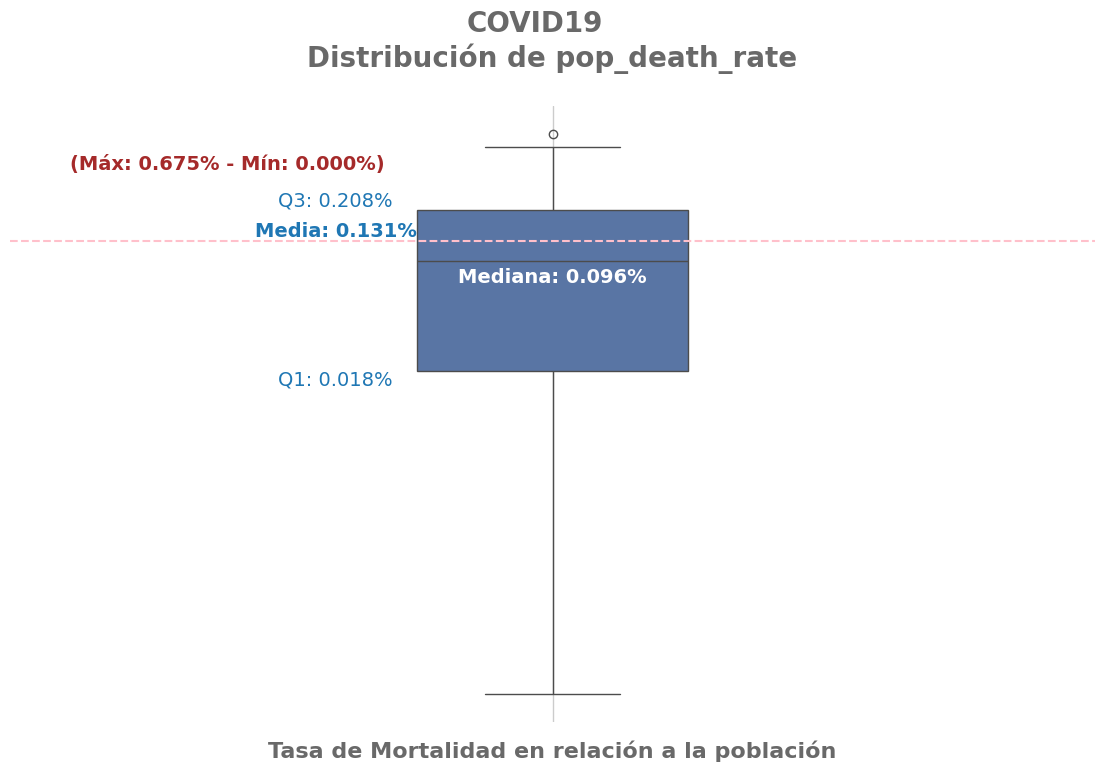

(0.0, 0.018, 0.096, 0.1305757811975135, 0.208, 0.675)

In [239]:
df_new = df_covid_and_population
columnas = ['pop_death_rate']

def graf_boxplot(df_new,columnas,title,suptitle,xlabel,round,simbolo):
  for columna in columnas:
    # round=3
    sns.set(style="whitegrid", rc={"figure.figsize": (14, 8)})

    cuartiles = [0, 0.25, 0.5, 0.75, 1]
    valores = df_new[columna].quantile(cuartiles).round(round)
    colores = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

    sns.boxplot(y=columna, data=df_new, orient='v', palette=colores, whis=2, width=0.25)

    # Configura el eje y en escala logarítmica
    plt.yscale("log")

    # Línea marcando el promedio:
    plt.axhline(y=df_new[columna].mean(), linestyle='--', color='#FFC0CB')

    # Calcular los valores de los bigotes
    iqr = valores[0.75] - valores[0.25]
    bigote_sup = min(valores[1], valores[0.75] + 1.5 * iqr)
    bigote_inf = max(valores[0], valores[0.25] - 1.5 * iqr)

    # Coloco valores en el gráfico:
    plt.text(-0.3, bigote_sup, f'(Máx: {valores[1]:.3f}{simbolo} - Mín: {valores[0]:.3f}{simbolo})', fontsize=14, ha='center', va='top', color='brown',fontweight='bold')
    plt.text(-0.2, valores[0.25], f'Q1: {valores[0.25]}{simbolo}', fontsize=14, ha='center', va='top', color='#1f77b4')
    plt.text(-0.2, valores[0.75], f'Q3: {valores[0.75]}{simbolo}', fontsize=14, ha='center', va='bottom', color='#1f77b4')
    plt.text(-0.2, df_new[columna].mean(), f'Media: {df_new[columna].mean():.3f}%', fontsize=14, ha='center', va='bottom', color='#1f77b4',fontweight='bold')

    # Calcular la mediana para colocar el valor en el gráfico
    mediana = np.median(df_new[columna]).round(round)
    plt.text(0, mediana*0.9, f'Mediana: {mediana}{simbolo}', fontsize=14, ha='center', va='top', color='white',fontweight='bold')

    plt.title(f'{title} {columna}', fontsize=20,fontweight='bold',color='dimgray',y=1.05)
    plt.suptitle(suptitle, fontsize=20,fontweight='bold',color='dimgray', y=1)
    plt.xlabel(xlabel,fontsize=16,fontweight='bold',color='dimgray')
    plt.ylabel('')
    plt.yticks([])
    plt.grid(None)
    plt.box(None)
    plt.xlim()
    plt.show()
  return valores[0],valores[0.25],mediana, df_new[columna].mean(),valores[0.75],valores[1]
graf_boxplot(df_new = df_covid_and_population,
             columnas = ['pop_death_rate'],
             title='Distribución de',
             suptitle='COVID19',
             xlabel='Tasa de Mortalidad en relación a la población',
             round=3,
             simbolo='%')

##GRAFICA_ FIRST INSIGHT:

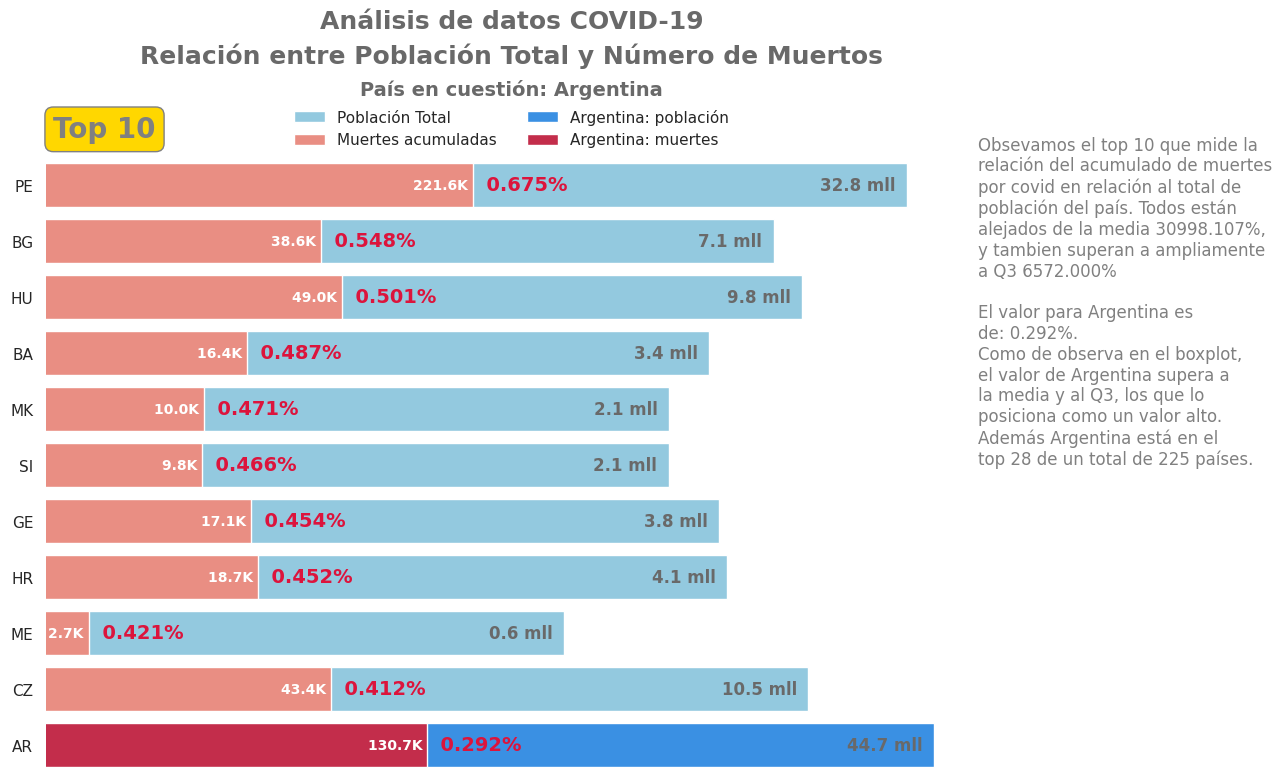

In [176]:
### pais para unir:
# pais_x= 'Argentina'
cantidad_paises=len(df_covid_and_population)
indice_pais_x = df_covid_and_population[df_covid_and_population['Country'] == pais_x].index[0]

pais_x_row = df_covid_and_population[df_covid_and_population['Country'] == pais_x]

top_10_paises = df_covid_and_population.nlargest(10, 'pop_death_rate')
top_10_paises_and_pais_x = pd.concat([top_10_paises, pais_x_row])


# Crear un gráfico de barras horizontal con tres barras por país
plt.figure(figsize=(12, 8))
sns.barplot(x='Total_Population', y='Country_code', data=top_10_paises_and_pais_x, color='skyblue', label='Población Total')
sns.barplot(x='Cumulative_deaths', y='Country_code', data=top_10_paises_and_pais_x, color='salmon', label='Muertes acumuladas')
# sns.barplot(x='nueva', y='Country_code', data=top_10_paises_and_pais_x, color='green')
sns.barplot(x='Total_Population', y='Country_code', data=top_10_paises_and_pais_x.iloc[-1:], color='dodgerblue',label=f'{pais_x}: población')
sns.barplot(x='Cumulative_deaths', y='Country_code', data=top_10_paises_and_pais_x.iloc[-1:], color='crimson',label=f'{pais_x}: muertes')

plt.xscale('log')

# Configurar el gráfico
plt.xlabel('Valores (por miles)')
plt.ylabel('Código de País')
plt.title('Relación entre Población Total y Número de Muertos',pad=.9, y=1.15,fontsize=18, fontweight='bold', color='dimgray')
plt.annotate('Análisis de datos COVID-19', xy=(0.5, 1.22), xycoords='axes fraction', ha='center', va='center', fontsize=18, fontweight='bold', color='dimgray')
plt.annotate(f'País en cuestión: {pais_x}', xy=(0.5, 1.11), xycoords='axes fraction', ha='center', va='center', fontsize=14, fontweight='bold', color='dimgray')
plt.legend()

# Valores población total al final de las barras
for i, (value, country_code) in enumerate(zip(top_10_paises_and_pais_x['Total_Population'], top_10_paises_and_pais_x['Country_code'])):
    plt.text(value, i, f'{value/1e6:,.1f} mll  ', va='center', ha='right',fontsize=12, color='dimgray',fontweight='bold')

# Número de muertos al final de las barras: 'Cumulative_deaths'
for i, (value, country_code) in enumerate(zip(top_10_paises_and_pais_x['Cumulative_deaths'], top_10_paises_and_pais_x['Country_code'])):
    plt.text(value, i, f'{value/1e3:,.1f}K ', va='center', ha='right', fontsize=10, color='white', fontweight='bold')

# Valores de pop_death_rate al final de las barras
for i, (value, death, country_code) in enumerate(zip(top_10_paises_and_pais_x['Cumulative_deaths'],top_10_paises_and_pais_x['pop_death_rate'], top_10_paises_and_pais_x['Country_code'])):
    plt.text(value, i, f'  {death:.3f}%', va='center', ha='left', fontsize=14, color='crimson',fontweight='bold')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2,frameon=False)

plt.annotate('Top 10', xy=(0, 1), xytext=(5, 30), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='gold'),
             fontsize=20, fontweight='bold', color='gray')

plt.annotate(f'''
Obsevamos el top 10 que mide la
relación del acumulado de muertes
por covid en relación al total de
población del país. Todos están
alejados de la media {df_new[columna].mean():.3f}%,
y tambien superan a ampliamente
a Q3 {valores[0.75]:.3f}%

El valor para {pais_x} es
de: {valor_pop_death_rate_pais_x:.3f}%.
Como de observa en el boxplot,
el valor de {pais_x} supera a
la media y al Q3, los que lo
posiciona como un valor alto.
Además {pais_x} está en el
top {indice_pais_x} de un total de {cantidad_paises} países.
''',
             xy=(1, 1), xytext=(1, 30), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top',fontsize=12, color='gray')

plt.ylabel(None)
plt.xlabel(None)
sns.despine()
plt.xticks([])
plt.box(None)
plt.show()


In [177]:
total_death_rate = df_covid_and_population.groupby('Country')['pop_death_rate'].max().sort_values(ascending=False)
top_death_rate = total_death_rate.nlargest(30)
top_death_rate

Country
Peru                                                    0.675046
Bulgaria                                                0.548030
Hungary                                                 0.501198
Bosnia and Herzegovina                                  0.487397
North Macedonia                                         0.471247
Slovenia                                                0.465568
Georgia                                                 0.454332
Croatia                                                 0.452497
Montenegro                                              0.421005
Czechia                                                 0.411991
Republic of Moldova                                     0.391672
Latvia                                                  0.389501
Slovakia                                                0.388803
San Marino                                              0.368658
Greece                                                  0.364005
Romania          

In [178]:
### Buscar diferencias en codigos de país:

merged_df = pd.merge(df1, df2, on='Country_code', how='outer', indicator=True)
diff = merged_df[merged_df['_merge'] != 'both']
print("Diferencias en 'Country_code':")
diff[['Country_code', 'Country', '_merge']]


Diferencias en 'Country_code':


,Country_code,Country,_merge
230,PN,Pitcairn,left_only
233,EH,NaN,right_only
234,HK,NaN,right_only
235,MO,NaN,right_only
236,TW,NaN,right_only


## Seleccionar top 10

In [179]:
replacements = {
    "United States of America": "USA",
    "United Kingdom of Great Britain and Northern Ireland": "U. Kingdom",
    "Republic of Korea": "Korea"
}

top_10 = df_covid_and_population.head(10)
top_10['Country'] = top_10['Country'].replace(replacements)
top_10

,Country_code,Country,Cumulative_cases,Cumulative_deaths,lethality_rate,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy_0,Population_Sex_Ratio,Median_Age,Life_Expectancy_15,Life_Expectancy_65,Life_Expectancy_80,pop_death_rate
0,PE,Peru,4536733,221583,4.88,32824860,16268182,16556679,25.643,76.156,98.258,27.694,62.449,17.437,7.035,0.675046
1,BG,Bulgaria,1325067,38650,2.92,7052532,3420914,3631617,65.063,75.062,94.198,43.919,60.674,16.231,7.121,0.548030
2,HU,Hungary,2228206,48976,2.20,9771796,4678593,5093203,107.940,76.454,91.860,42.121,61.870,16.880,7.844,0.501198
3,BA,Bosnia and Herzegovina,403508,16380,4.06,3360711,1652504,1708207,65.643,77.241,96.739,41.149,62.735,15.764,6.967,0.487397
4,MK,North Macedonia,350244,9963,2.84,2114176,1054637,1059539,84.862,77.293,99.537,37.611,62.899,15.905,6.782,0.471247
5,SI,Slovenia,1354807,9837,0.73,2112901,1058072,1054830,104.921,81.604,100.307,42.641,66.842,19.510,9.204,0.465568
6,GE,Georgia,1855289,17132,0.92,3770811,1774749,1996062,54.264,73.470,88.913,36.202,59.237,15.043,6.546,0.454332
7,HR,Croatia,1309728,18687,1.43,4129752,2007499,2122252,73.883,78.738,94.593,43.262,64.145,17.396,7.854,0.452497
8,ME,Montenegro,251280,2654,1.06,630396,307383,323013,45.641,77.040,95.161,37.680,62.338,16.482,7.571,0.421005
9,CZ,Czechia,4750980,43411,0.91,10536871,5189271,5347600,136.483,79.243,97.039,41.880,64.556,18.279,8.284,0.411991


In [180]:
x_row = df_covid_and_population[df_covid_and_population['Country_code'] == 'AR']
x_row

,Country_code,Country,Cumulative_cases,Cumulative_deaths,lethality_rate,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy_0,Population_Sex_Ratio,Median_Age,Life_Expectancy_15,Life_Expectancy_65,Life_Expectancy_80,pop_death_rate
28,AR,Argentina,10076858,130695,1.3,44745520,22153370,22592150,16.027,77.284,98.058,30.781,63.265,17.881,8.991,0.292085


In [181]:
top_10_pais=top_10[['Country_code','Country',	'Cumulative_cases']]
top_10_pais

,Country_code,Country,Cumulative_cases
0,PE,Peru,4536733
1,BG,Bulgaria,1325067
2,HU,Hungary,2228206
3,BA,Bosnia and Herzegovina,403508
4,MK,North Macedonia,350244
5,SI,Slovenia,1354807
6,GE,Georgia,1855289
7,HR,Croatia,1309728
8,ME,Montenegro,251280
9,CZ,Czechia,4750980


In [182]:
list_top_10_pais=list(top_10_pais.Country)
list_top_10_pais

['Peru',
 'Bulgaria',
 'Hungary',
 'Bosnia and Herzegovina',
 'North Macedonia',
 'Slovenia',
 'Georgia',
 'Croatia',
 'Montenegro',
 'Czechia']

In [183]:
list_top_10_pais_and_otros = list(list_top_10_pais)  # Crear una nueva lista para evitar modificar la original
# list_top_10_pais_and_otros.extend(['Otros'])
list_top_10_pais_and_otros.insert(0, 'Otros')  # Insertar 'Otros' en el primer lugar

print(list_top_10_pais_and_otros)

['Otros', 'Peru', 'Bulgaria', 'Hungary', 'Bosnia and Herzegovina', 'North Macedonia', 'Slovenia', 'Georgia', 'Croatia', 'Montenegro', 'Czechia']


In [184]:
total_case=df_covid_and_population.Cumulative_cases.sum()
print('Total de casos:', total_case)

Total de casos: 774002785


In [185]:
total_top10=top_10_pais.Cumulative_cases.sum()
print('total_top10:', total_top10)
otros=total_case-total_top10
print('total del resto:', otros)

total_top10: 18365842
total del resto: 755636943


#Pregunta 1

1. ¿Cómo ha evolucionado el Covid-19 en el país en comparación con el impacto observado a nivel global?

**Para realizar este análisis necesitamos construir 2 bases de datos diferentes para los 2 gráficos mostrados: Worldwide Cases Distribution**

In [186]:
# Worldwide Distribution

### PAIS A BUSCAR:
total_por_pais = df_covid_limpio.groupby('Country')['Cumulative_cases'].max().sort_values(ascending=False)
top_10_paises = total_por_pais.nlargest(5)

In [187]:
# pais_x='Argentina'
ver_pais = total_por_pais.index.isin([pais_x]) ###Verfico si el pais esta presente
list_pais_X = total_por_pais.loc[ver_pais]
list_pais_X

Country
Argentina    10076858
Name: Cumulative_cases, dtype: int64

In [188]:
pais_buscar = 'Argentina'

# Encontrar el índice de la fila donde el país es 'Argentina'
indice_pais_x = df_covid_and_population['Country'].eq(pais_buscar).idxmax()
indice_pais_x

28

In [189]:
total_por_pais = df_covid_limpio.groupby('Country')['Cumulative_cases'].max().sort_values(ascending=False)
df_total_por_pais=pd.DataFrame(total_por_pais)
df_total_por_pais.reset_index(inplace=True)
df_total_por_pais

,Country,Cumulative_cases
0,USA,103436829
1,China,99325108
2,India,45021758
3,France,38997490
4,Germany,38437756
...,...,...
228,Holy See,26
229,Pitcairn,4
230,Yemen,1
231,Democratic People's Republic of Korea,0


In [190]:
# # Worldwide Distribution

# ### PAIS A BUSCAR:
total_por_pais = df_covid_limpio.groupby('Country')['Cumulative_cases'].max().sort_values(ascending=False)
top_10_paises = total_por_pais.nlargest(5)
top_10_paises_and_x=top_10_paises.append(list_pais_X)
otros = total_por_pais.drop(top_10_paises_and_x.index).sum()
top_10_paises_and_x['Otros'] = otros
top_10_paises_and_x = top_10_paises_and_x.sort_values(ascending=False)

top_10_paises_and_x

Country
Otros        438700234
USA          103436829
China         99325108
India         45021758
France        38997490
Germany       38437756
Argentina     10076858
Name: Cumulative_cases, dtype: int64

In [191]:
### ADICIONAR PAIS X
top_10_paises=top_10_paises.append(list_pais_X)

In [192]:
top_10_paises['Otros'] = otros
top_10_paises

Country
USA          103436829
China         99325108
India         45021758
France        38997490
Germany       38437756
Argentina     10076858
Otros        438700234
Name: Cumulative_cases, dtype: int64

In [193]:
total_por_pais

Country
USA                                      103436829
China                                     99325108
India                                     45021758
France                                    38997490
Germany                                   38437756
                                           ...    
Holy See                                        26
Pitcairn                                         4
Yemen                                            1
Democratic People's Republic of Korea            0
Turkmenistan                                     0
Name: Cumulative_cases, Length: 233, dtype: int64

In [194]:
df_top_10_paises=pd.DataFrame(top_10_paises_and_x)
df_top_10_paises['Country']=df_top_10_paises.index
df_top_10_paises.reset_index(drop=True, inplace=True)
df_top_10_paises.sort_values(by='Cumulative_cases', ascending=False)
df_top_10_paises

,Cumulative_cases,Country
0,438700234,Otros
1,103436829,USA
2,99325108,China
3,45021758,India
4,38997490,France
5,38437756,Germany
6,10076858,Argentina


In [195]:
replacements = {
    "United States of America": "USA",
    "United Kingdom of Great Britain and Northern Ireland": "U. Kingdom",
    "Republic of Korea": "Korea"
}
df_top_10_paises['Country'] = df_top_10_paises['Country'].replace(replacements)
df_top_10_paises.sort_values(by='Cumulative_cases', ascending=False)
df_top_10_paises

,Cumulative_cases,Country
0,438700234,Otros
1,103436829,USA
2,99325108,China
3,45021758,India
4,38997490,France
5,38437756,Germany
6,10076858,Argentina


In [196]:
listas = []

for index, row in df_top_10_paises.iterrows():
    listas.append(f'{row["Country"]}: {round(row["Cumulative_cases"]/1e6,1)} mll')

print(listas)

['Otros: 438.7 mll', 'USA: 103.4 mll', 'China: 99.3 mll', 'India: 45.0 mll', 'France: 39.0 mll', 'Germany: 38.4 mll', 'Argentina: 10.1 mll']


In [197]:
colors = sns.color_palette('Reds_r', len(top_10_paises_and_x))
print(colors)

[(0.6476432141484045, 0.05896193771626297, 0.08247597078046903), (0.7971856978085351, 0.09519415609381007, 0.11418685121107267), (0.9378085351787774, 0.23354094579008075, 0.17393310265282583), (0.9843752402921953, 0.4181468665897732, 0.2926566705113418), (0.9882352941176471, 0.5757016532103036, 0.4506728181468666), (0.9884198385236448, 0.7367474048442906, 0.6358938869665514), (0.9961860822760477, 0.8806920415224914, 0.8267589388696654)]


In [198]:
top_5_paises = total_por_pais.nlargest(5)
top_5_paises=top_5_paises.append(list_pais_X)
top_5_paises

Country
USA          103436829
China         99325108
India         45021758
France        38997490
Germany       38437756
Argentina     10076858
Name: Cumulative_cases, dtype: int64

## GRAFICA pregunta 1


In [199]:

indice_pais_x = df_total_por_pais[df_total_por_pais['Country'] == pais_x].index[0]
valor_Cumulative_cases_pais_x = df_total_por_pais.loc[indice_pais_x, 'Cumulative_cases']
print(f'indice_pais_x: {pais_x} - index:', indice_pais_x)
print('valor_Cumulative_cases_pais_x:',valor_Cumulative_cases_pais_x)

indice_pais_x: Argentina - index: 15
valor_Cumulative_cases_pais_x: 10076858


Text(0, 0, '\nObsevamos en ambas gráficas el top 5:\nLa gráfica tipo pie muestra la distribución de casos reportados\nde covid y la gráfica de líneas representa la progresión temporal\nindicada en días del número de contagios.\n\nArgentina, en color rojo, se ubica en el top 15 con 10.08 mll.\n\nLa curva que corresponde a Argentina, describe un crecimiento continuo y suave en relación a los top 5, aunque\nexperimenta una meseta entre lo 600 y 700 días y luego una leve pendiente positiva antes de llegar a los 800 días,\nluego experimenta una meseta casi constante, marcando el máximo.\n')

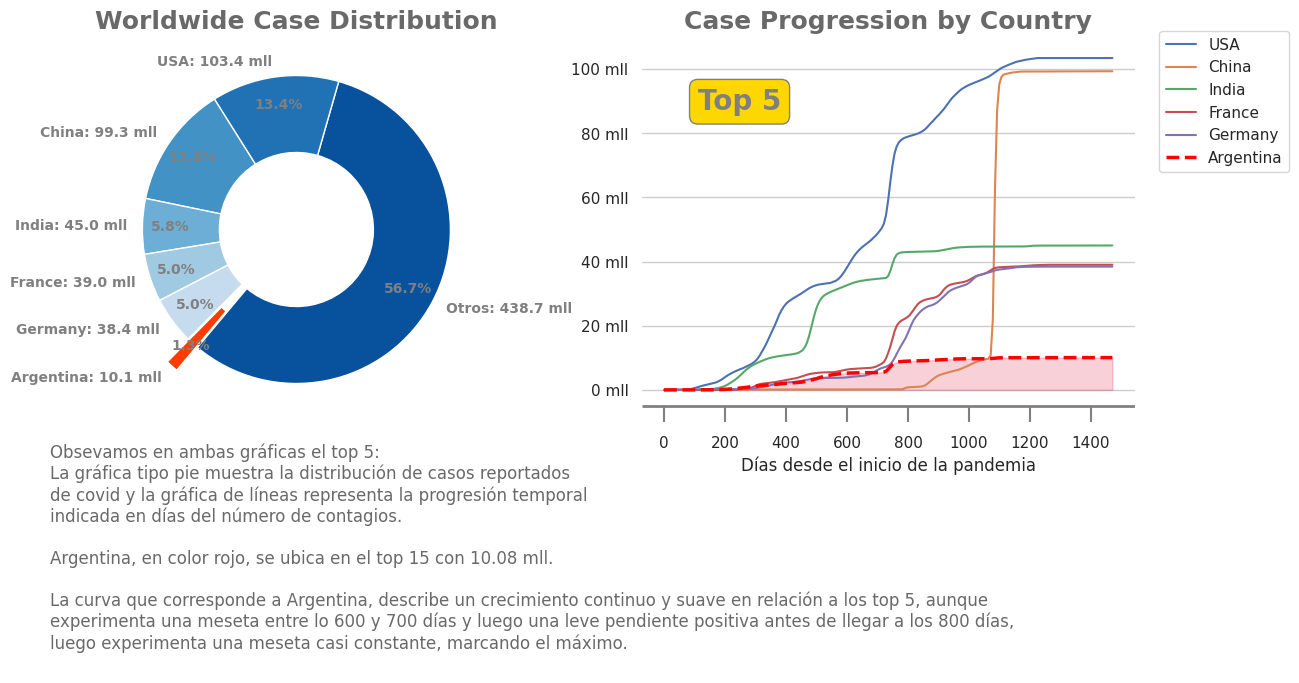

In [375]:
title='Worldwide Case Distribution'
# Gráfico de Donuts
explode = (0,0,0,0,0,0, 0.2)  # Explode solo la porción B
colors = sns.color_palette('Blues_r', len(top_10_paises_and_x))

colors[-1] = (1, 0.230, 0)

label_props = {'fontsize': 10,'color':'gray','fontweight':'bold'}
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
wedges, texts, autotexts = axs[0].pie(top_10_paises_and_x,labels=listas, autopct='%1.1f%%', textprops=label_props, pctdistance=0.82, startangle=-130,explode=explode, wedgeprops=dict(width=0.5, edgecolor='w'),colors=colors)
axs[0].set_title(title, fontsize=18, color='dimgray', fontweight='bold')

### seleccion de país X
# pais_x='Argentina'
ver_pais = total_por_pais.index.isin([pais_x])
list_pais_X = total_por_pais.loc[ver_pais]

# Case Progression by Country
total_por_pais = df_covid_limpio.groupby('Country')['Cumulative_cases'].max().sort_values(ascending=False)
top_5_paises = total_por_pais.nlargest(5)
top_5_paises_and_x=top_5_paises.append(list_pais_X)

df_covid_limpio_reset = df_covid_limpio.reset_index()
df_top_5 = df_covid_limpio_reset[df_covid_limpio_reset['Country'].isin(top_5_paises_and_x.index)]
total_acumulado_top_5 = df_top_5.pivot(index='Country', columns='Date_reported', values='Cumulative_cases').fillna(0)

# Gráfico de Líneas
title_lineas='Case Progression by Country'
def millions_formatter(value, pos):
    return f'{value / 1e6:.0f} mll'

for pais in top_5_paises_and_x.index:
    days_since_start = (total_acumulado_top_5.columns - total_acumulado_top_5.columns[0]).days
    # axs[1].plot(days_since_start, total_acumulado_top_5.loc[pais], label=pais)
    if pais == pais_x:
        axs[1].plot(days_since_start, total_acumulado_top_5.loc[pais], label=pais, linewidth=2.5, linestyle='--',color='red')
        axs[1].fill_between(days_since_start, total_acumulado_top_5.loc[pais], color='crimson', alpha=0.2)

    else:
        axs[1].plot(days_since_start, total_acumulado_top_5.loc[pais], label=pais)

axs[1].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
# axs[1].xaxis.set_visible(True)  # Ocultar el eje x
axs[1].set_xlabel('Días desde el inicio de la pandemia')
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
axs[1].set_frame_on(False)
axs[1].legend(loc=(1.05,0.65))
axs[1].set_title(title_lineas, fontsize=18, color='dimgray', fontweight='bold')
axs[1].xaxis.grid(False)

# límites reales del eje x
xmin, xmax = axs[1].get_xlim()
axs[1].set_xlim(xmin,xmax)

# Añade una línea horizontal:
axs[1].hlines(-5e6, xmin=xmin, xmax=xmax, color='gray', linestyle='-', linewidth=2)
# Puas marcadores de días7

for tick in axs[1].get_xticks():
    axs[1].vlines(tick, ymin=-5e6, ymax=-14e6, color='gray', linestyle='-', linewidth=1.5)

plt.box([])
axs[1].annotate('Top 5', xy=(0.1, 0.76), xytext=(5, 30), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='gold'),
             fontsize=20, fontweight='bold', color='gray')
axs[1].set_ylim(-10e6,110e6)
plt.annotate(f'''
Obsevamos en ambas gráficas el top 5:
La gráfica tipo pie muestra la distribución de casos reportados
de covid y la gráfica de líneas representa la progresión temporal
indicada en días del número de contagios.

{pais_x}, en color rojo, se ubica en el top {indice_pais_x} con {valor_Cumulative_cases_pais_x/1e6:.2f} mll.

La curva que corresponde a {pais_x}, describe un crecimiento continuo y suave en relación a los top 5, aunque
experimenta una meseta entre lo 600 y 700 días y luego una leve pendiente positiva antes de llegar a los 800 días,
luego experimenta una meseta casi constante, marcando el máximo.
''',
             xy=(-1.2, 0), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top',fontsize=12, color='dimgray')


In [202]:
# pais_x='Argentina'
ver_pais = total_por_pais.index.isin([pais_x])
list_pais_X = total_por_pais.loc[ver_pais]
list_pais_X

Country
Argentina    10076858
Name: Cumulative_cases, dtype: int64

#Pregunta 3

3. ¿Cuál es la evolución del índice de letalidad del Covid-19 en el país, comparado con los países con los índices históricos más elevados?

**Para realizar este análisis necesitamos construir primero la base de datos para usarla en el gráfico mostrado:**

**Lethality Rate by Country**

In [203]:
#Lethality Rate by Country
def get_max_row(group, column):
    return group.loc[group[column].idxmax()]

result = df_covid_limpio.groupby(['Country', df_covid_limpio['Date_reported'].dt.to_period("M")]).apply(lambda group: get_max_row(group, 'lethality_rate'))
result.reset_index(drop=True, inplace=True)
top_5_paises = result.groupby('Country')['lethality_rate'].mean().nlargest(5).index
result = result[result['Country'].isin(top_5_paises)]
result_pais = df_covid_limpio[df_covid_limpio['Country'] == pais_x].groupby(df_covid_limpio['Date_reported'].dt.to_period("M")).apply(lambda group: get_max_row(group, 'lethality_rate'))
result_pais.reset_index(drop=True, inplace=True)
result_final = pd.concat([result, result_pais])
result_final

,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
2982,2020-01-05,EG,Egypt,0,0,0,0,0.000000
2983,2020-02-02,EG,Egypt,0,0,0,0,0.000000
2984,2020-03-29,EG,Egypt,282,576,26,36,6.250000
2985,2020-04-12,EG,Egypt,869,1939,75,146,7.529654
2986,2020-05-03,EG,Egypt,1874,6193,108,415,6.701114
...,...,...,...,...,...,...,...,...
44,2023-09-03,AR,Argentina,3104,10059917,15,130571,1.297933
45,2023-10-01,AR,Argentina,1317,10067998,9,130634,1.297517
46,2023-11-19,AR,Argentina,532,10073197,7,130678,1.297284
47,2023-12-03,AR,Argentina,608,10074309,1,130682,1.297181


In [206]:
replacements = {
    "Syrian Arab Republic": "Arabia",
    "United Kingdom of Great Britain and Northern Ireland": "U. Kingdom",
    "Republic of Korea": "Korea"
}
result_final['Country'] = result_final['Country'].replace(replacements)
result_final.sort_values(by='Cumulative_cases', ascending=False)
#Syrian Arab Republic
result_final


,Date_reported,Country_code,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
2982,2020-01-05,EG,Egypt,0,0,0,0,0.000000
2983,2020-02-02,EG,Egypt,0,0,0,0,0.000000
2984,2020-03-29,EG,Egypt,282,576,26,36,6.250000
2985,2020-04-12,EG,Egypt,869,1939,75,146,7.529654
2986,2020-05-03,EG,Egypt,1874,6193,108,415,6.701114
...,...,...,...,...,...,...,...,...
44,2023-09-03,AR,Argentina,3104,10059917,15,130571,1.297933
45,2023-10-01,AR,Argentina,1317,10067998,9,130634,1.297517
46,2023-11-19,AR,Argentina,532,10073197,7,130678,1.297284
47,2023-12-03,AR,Argentina,608,10074309,1,130682,1.297181


In [207]:
max_date_rate_pais_x = result_final[result_final['Country'] == pais_x][['Date_reported','lethality_rate']]
max_date_rate_pais_x.iloc[-2][0]


Timestamp('2023-12-03 00:00:00')

###Grafica de distribución de frec. de lethality rate

In [253]:
# agrupando máx de lethality rate por país para posterior graficación:
max_lethality_rates = df_covid_limpio.groupby('Country')['lethality_rate'].max()

df_max_lethality_rates = max_lethality_rates.reset_index()
df_max_lethality_rates.sort_values(by='lethality_rate', ascending=False,inplace=True)
df_max_lethality_rates.reset_index(drop=True,inplace=True)

df_max_lethality_rates = df_max_lethality_rates[df_max_lethality_rates['lethality_rate'] != 0]
indices_pais_x = df_max_lethality_rates[df_max_lethality_rates['Country'] == pais_x].index
print(indices_pais_x[0])
df_max_lethality_rates

63


,Country,lethality_rate
0,Netherlands (Kingdom of the),12.267776
1,San Marino,12.260536
2,Mexico,12.245245
3,Belgium,12.147834
4,Sweden,12.029859
...,...,...
219,Bhutan,0.123001
220,Saint Pierre and Miquelon,0.120773
221,Tuvalu,0.033979
222,Cook Islands,0.028494


## GRAFICA pregunta 3

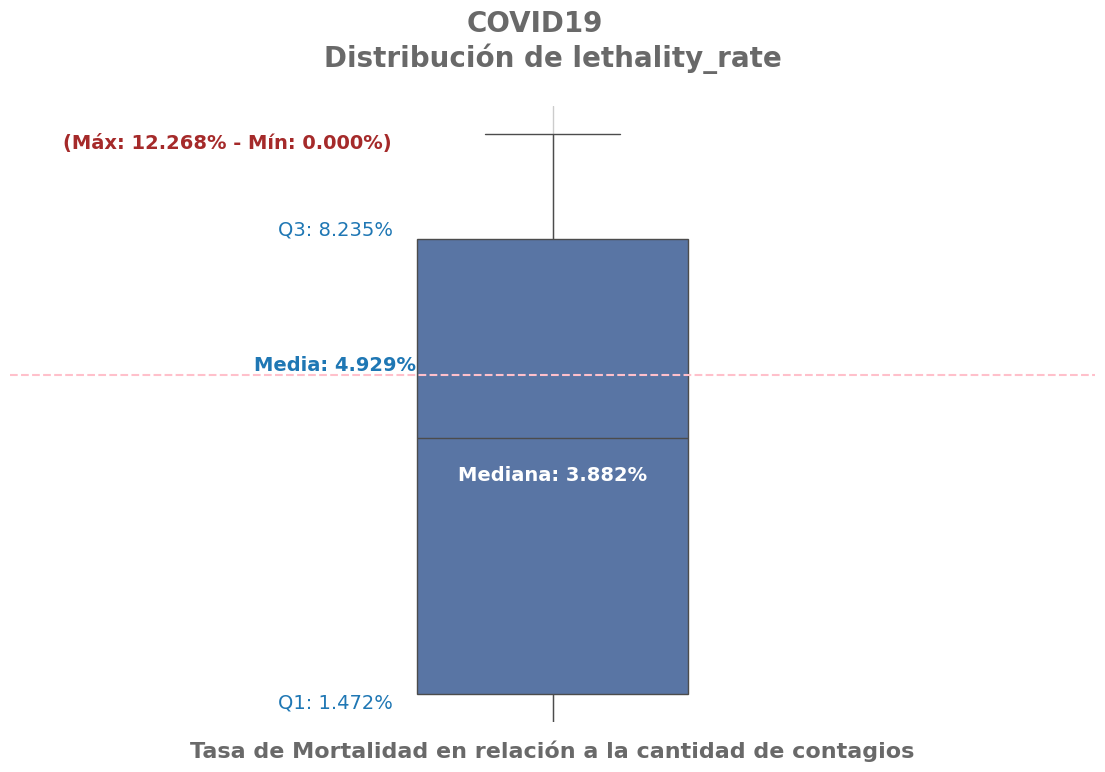

(0.0, 1.472, 3.882, 4.928520024914639, 8.235, 12.268)

In [237]:
distribuciones=graf_boxplot(df_new = df_max_lethality_rates,
             columnas = ['lethality_rate'],
             title='Distribución de',
             suptitle='COVID19',
             xlabel='Tasa de Mortalidad en relación a la cantidad de contagios',
             round=3,
             simbolo='%')[:]
distribuciones

In [244]:
media=distribuciones[3].round(3)
media

4.929

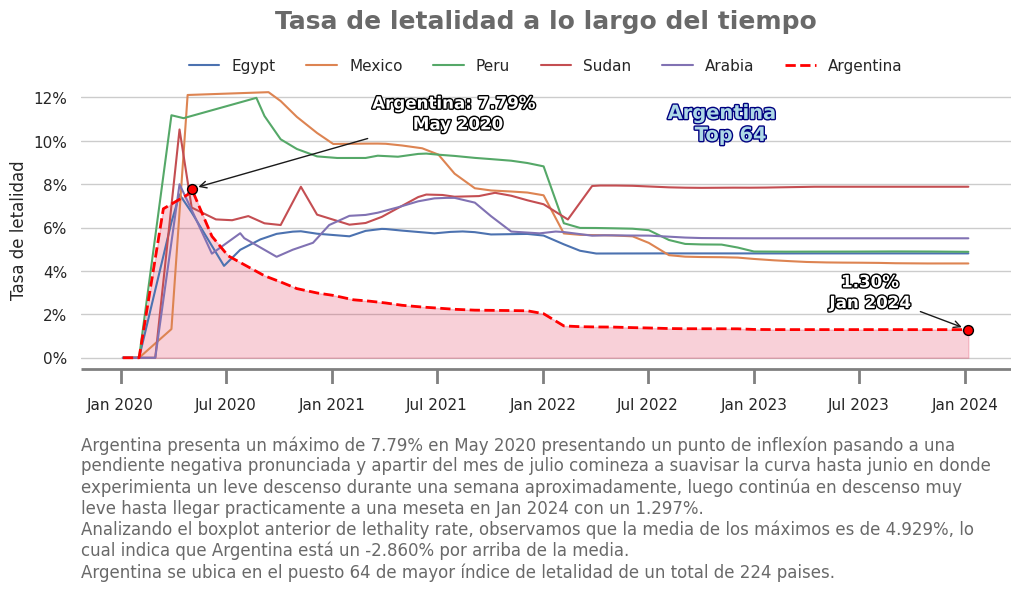

In [289]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.patheffects import withStroke

# Crea el gráfico de líneas
fig, ax = plt.subplots(figsize=(12, 4))

#obtener el valor maximo para pais_x
max_letality_rate_pais_x = result_final[result_final['Country'] == pais_x]['lethality_rate'].max()

# Itera sobre los países y dibuja las líneas
for pais in result_final['Country'].unique():
    country_data = result_final[result_final['Country'] == pais]

    # Ajusta el grosor y estilo de la línea para el país especificado
    if pais == pais_x:
        ax.plot(country_data['Date_reported'], country_data['lethality_rate'], label=pais, linewidth=2, linestyle='--',color='red')
        ax.fill_between(country_data['Date_reported'], country_data['lethality_rate'], color='crimson', alpha=0.2)
    else:
        ax.plot(country_data['Date_reported'], country_data['lethality_rate'], label=pais)

# Configura leyenda y etiquetas
ax.legend()
ax.set_ylabel('Tasa de letalidad')
ax.set_title('Tasa de letalidad a lo largo del tiempo',pad=.9, y=1.15,fontsize=18, fontweight='bold', color='dimgray')

# Configura el formato de las fechas en el eje x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Agrega el símbolo de porcentaje (%) a las etiquetas del eje y
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

# Configura el formato de las etiquetas del eje y para mostrar números enteros
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}%'))

# Oculta las líneas verticales del eje x
ax.tick_params(axis='x', which='both', bottom=False)
ax.xaxis.grid(False)
plt.box([])
ax.set_ylim(-1.2,13)

# Obtén los límites reales del eje x
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin,xmax)

# Añade una línea horizontal en y=0
ax.hlines(-0.50, xmin=xmin, xmax=xmax, color='gray', linestyle='-', linewidth=2)

for tick in ax.get_xticks():
    ax.vlines(tick, ymin=-1.5, ymax=-0.5, color='gray', linestyle='-', linewidth=2)

# for tick in ax.get_xticks():
#     ax.vlines(tick, ymin=-1.5, ymax=12, color='gray', linestyle='--', linewidth=.5)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(result_final.Country.unique()),frameon=False)

### Valores máx, mín y fechas del pais_x:
fecha_max_lethality_rate = pd.to_datetime(result_final[result_final["lethality_rate"] == max_letality_rate_pais_x]["Date_reported"].values[0]).strftime("%b %Y")
porc_max_lethality_rate = max_letality_rate_pais_x
fecha_min_lethality_rate = max_date_rate_pais_x.iloc[-1][0].strftime("%b %Y")
porc_min_lethality_rate = round(max_date_rate_pais_x.iloc[-1][1],3)
# Flecha y anotación:
ax.annotate(f'{pais_x}: {porc_max_lethality_rate:.2f}%\n       {fecha_max_lethality_rate}',
             xy=(result_final[result_final['lethality_rate'] == max_letality_rate_pais_x]['Date_reported'].values[0], max_letality_rate_pais_x),
             xytext=(130,  max_letality_rate_pais_x*5.5),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color="k", shrinkA=5, shrinkB=5),
             fontsize=12,
             color='white',
             fontweight='bold',
             path_effects=[withStroke(linewidth=2, foreground='black')])

# Punto en el valor máximo de la tasa de letalidad para pais_x
ax.scatter(result_final[result_final['lethality_rate'] == max_letality_rate_pais_x]['Date_reported'].values[0],
           max_letality_rate_pais_x, color='red', s=50,edgecolor='black',zorder=5)

max_date_rate_pais_x = result_final[result_final['Country'] == pais_x][['Date_reported','lethality_rate']]

ax.annotate(f'  {porc_min_lethality_rate:.2f}%\n{fecha_min_lethality_rate}',
             xy=(max_date_rate_pais_x.iloc[-1][0], max_date_rate_pais_x.iloc[-1][1]),
             xytext=(-100,  max_letality_rate_pais_x*2),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color="k", shrinkA=5, shrinkB=5),
             fontsize=12,
             color='white',
             fontweight='bold',
             path_effects=[withStroke(linewidth=2, foreground='black')])
ax.scatter(max_date_rate_pais_x.iloc[-1][0], max_date_rate_pais_x.iloc[-1][1], color='red', marker='o', edgecolors='black', s=50)

plt.annotate(f'''
{pais_x} presenta un máximo de {porc_max_lethality_rate:.2f}% en {fecha_max_lethality_rate} presentando un punto de inflexíon pasando a una
pendiente negativa pronunciada y apartir del mes de julio comineza a suavisar la curva hasta junio en donde
experimienta un leve descenso durante una semana aproximadamente, luego continúa en descenso muy
leve hasta llegar practicamente a una meseta en {fecha_min_lethality_rate} con un {porc_min_lethality_rate}%.
Analizando el boxplot anterior de lethality rate, observamos que la media de los máximos es de {media}%, lo
cual indica que {pais_x} está un {media-porc_max_lethality_rate:.3f}% por arriba de la media.
{pais_x} se ubica en el puesto {indices_pais_x[0]+1} de mayor índice de letalidad de un total de {len(df_max_lethality_rates)} paises.
''',
             xy=(0, -0.10), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top',fontsize=12, color='dimgray')

#Top pais_x en graf:
ax.annotate(f'{pais_x}\n    Top {indices_pais_x[0]+1}',
             xy=(max_date_rate_pais_x.iloc[-10][0],9),
             xytext=(-100,  max_letality_rate_pais_x*2),
             textcoords='offset points',
             fontsize=14,
             color='lightblue',
             fontweight='bold',
             path_effects=[withStroke(linewidth=2, foreground='navy')])

plt.show()


#Pregunta 4

4. Desde una perspectiva demográfica, ¿cuáles son las características que tienen un mayor impacto en el índice de letalidad de un país?

**Para realizar este análisis necesitamos construir primero la base de datos para usarla en el gráfico mostrado:**

**Características demográficas más relevantes**

In [273]:
df_median=df_population_limpio.sort_values(by='Median_Age',ascending=False)
# df_median=df_median[df_median['Country_code']=='AR']
df_median=df_median[df_median['Country_code']=='AR']
# df_median[['Region, subregion, country or area *','Country_code','Median_Age']]
df_median

,Country_code,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy_0,Population_Sex_Ratio,Median_Age,Life_Expectancy_15,Life_Expectancy_65,Life_Expectancy_80
194,AR,44745520,22153370,22592150,16.027,77.284,98.058,30.781,63.265,17.881,8.991


In [290]:
#Características demográficas más relevantes
df_filtrado = df_covid_limpio[df_covid_limpio['Date_reported'] <= '2020-12-31']
df_agrupado = df_filtrado.groupby(['Country_code', 'Country'], as_index=False)['lethality_rate'].mean()
df_final = pd.merge(df_agrupado, df_population_limpio, on='Country_code', how='inner')
columnas_seleccionadas = ['lethality_rate', 'Total_Population', 'Male_Population', 'Female_Population', 'Population_Density','Life_Expectancy_0','Life_Expectancy_15','Life_Expectancy_65','Life_Expectancy_80','Population_Sex_Ratio','Median_Age']
# columns_to_convert = ['Total_Population', 'Male_Population', 'Female_Population', 'Population_Density','Population_Sex_Ratio','Median_Age','Life_Expectancy_0','Life_Expectancy_15','Life_Expectancy_65','Life_Expectancy_80' ]

df_final = df_final[columnas_seleccionadas]

X = df_final.drop(['lethality_rate'], axis=1)
y = df_final['lethality_rate']
model_RF = RandomForestRegressor()
model_RF.fit(X, y)
feature_importances = pd.Series(model_RF.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances

Median_Age              0.176007
Female_Population       0.131246
Population_Sex_Ratio    0.127380
Life_Expectancy_80      0.116870
Population_Density      0.096546
Life_Expectancy_65      0.084934
Total_Population        0.081475
Male_Population         0.079487
Life_Expectancy_15      0.055718
Life_Expectancy_0       0.050336
dtype: float64

In [299]:
df_feature_importances=pd.DataFrame(feature_importances)
df_feature_importances.reset_index(inplace=True)
df_feature_importances.rename(columns={'index': 'variable', 0: 'valor'}, inplace=True)
df_feature_importances

,variable,valor
0,Median_Age,0.176007
1,Female_Population,0.131246
2,Population_Sex_Ratio,0.127380
3,Life_Expectancy_80,0.116870
4,Population_Density,0.096546
5,Life_Expectancy_65,0.084934
6,Total_Population,0.081475
7,Male_Population,0.079487
8,Life_Expectancy_15,0.055718
9,Life_Expectancy_0,0.050336


###Analizando métricas de evaluación del rendimiento de tu modelo de regresión lineal con SVM:

In [344]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = model_RF.predict(X_test)

# Calcula R^2
r2 = r2_score(y_test, y_pred)

# Calcula MSE
mse = mean_squared_error(y_test, y_pred)

# Calcula MAE
mae = mean_absolute_error(y_test, y_pred)

print(f'R^2: {r2:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'y_pred: {y_pred}')

R^2: 0.9288
MSE: 0.0009
MAE: 0.0196
y_pred: [0.34507494 0.02972471 0.14800492 0.00380419 0.04503501 0.00231985
 0.01302284 0.16477033 0.01412683 0.02227686 0.19354578 0.35008515
 0.0065233  0.24143679 0.2851655  0.23689078 0.17234417 0.01348148
 0.14309044 0.08665631 0.15646895 0.34719898 0.02849767 0.08027383
 0.10532997 0.15982894 0.02590799 0.0315318  0.00664539 0.11944878
 0.10541359 0.17427403 0.2589303  0.0086071  0.00655626 0.11771274
 0.00738131 0.11125774 0.11664028 0.04301117 0.07011069 0.01131439
 0.07551029 0.00200482 0.10439822]


R^2: 0.8793 sugiere un ajuste relativamente bueno!

## GRAFICA pregunta 4

###gráfica del % de importancia de las variables en relación a: lethality_rate


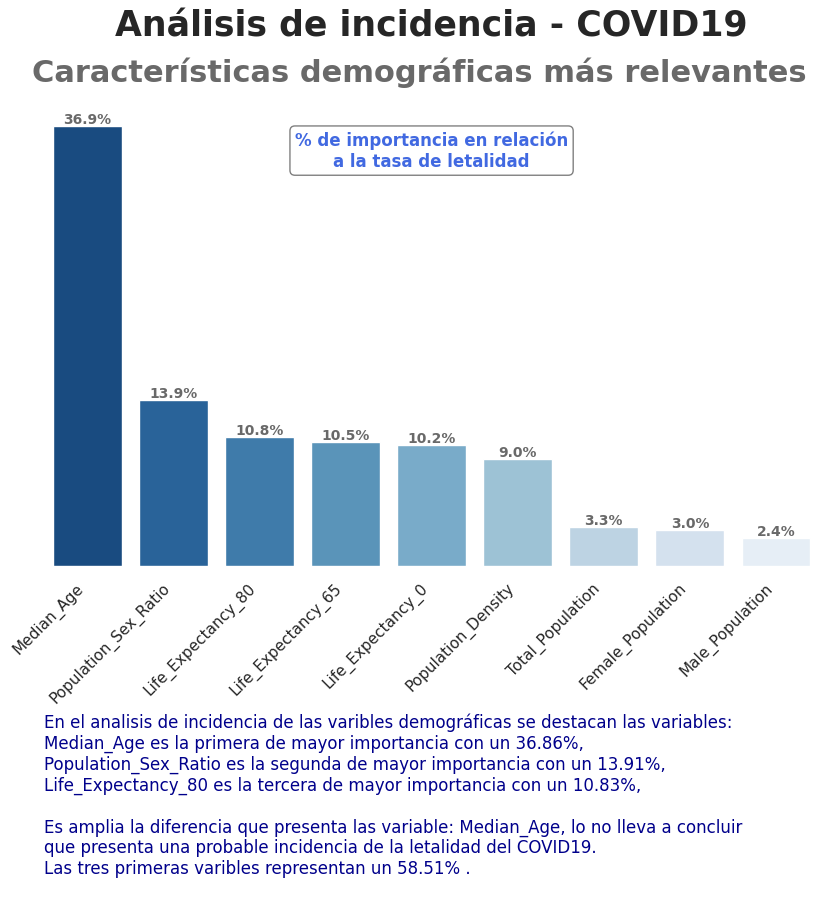

In [368]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_importances.index, y=feature_importances, palette='Blues_r', ax=ax,legend=False)

# Agrega valores al final de cada barra
for i, v in enumerate(feature_importances):
    ax.text(i, v, f'{v:.1%}', ha='center', va='bottom', fontsize=10, color='dimgray',fontweight='bold')

title='Análisis de incidencia - COVID19'
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title(title, y=1.13, fontsize=25, fontweight='bold')
plt.annotate('% de importancia en relación\na la tasa de letalidad', xy=(0.5, 0.9),
             xycoords='axes fraction', ha='center', va='center',
             fontsize=12, fontweight='bold', color='royalblue',
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='GRAY', facecolor='none'))

plt.suptitle('Características demográficas más relevantes',y=.96, fontsize=22, color='dimgray',fontweight='bold')
plt.box(None)

plt.annotate(f'''
En el analisis de incidencia de las varibles demográficas se destacan las variables:
{df_feature_importances['variable'][0]} es la primera de mayor importancia con un {df_feature_importances['valor'][0]:.2%},
{df_feature_importances['variable'][1]} es la segunda de mayor importancia con un {df_feature_importances['valor'][1]:.2%},
{df_feature_importances['variable'][2]} es la tercera de mayor importancia con un {df_feature_importances['valor'][2]:.2%},

Es amplia la diferencia que presenta las variable: {df_feature_importances['variable'][0]}, lo no lleva a concluir
que presenta una probable incidencia de la letalidad del COVID19.
Las tres primeras varibles representan un {df_feature_importances['valor'][0]+df_feature_importances['valor'][2]+df_feature_importances['valor'][2]:.2%} .
''',
             xy=(0, -0.27), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top',fontsize=12, color='darkblue')
plt.show()

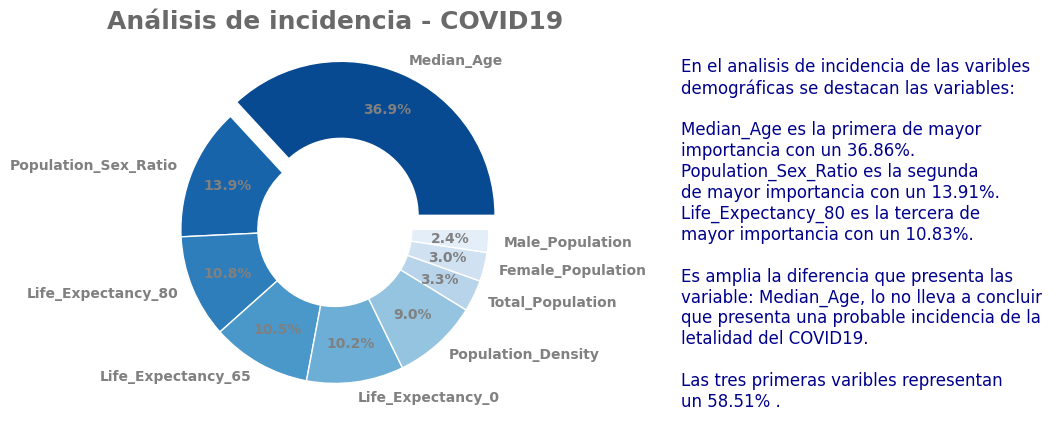

In [374]:
# Gráfico de Donuts
explode = (0.1,0,0,0,0,0,0,0,0)  # Explode solo la porción B
colors = sns.color_palette('Blues_r', len(df_feature_importances))

label_props = {'fontsize': 10,'color':'gray','fontweight':'bold'}
fig, axs = plt.subplots(figsize=(14, 5))
wedges, texts, autotexts = axs.pie(df_feature_importances.valor,explode=explode, autopct='%1.1f%%', textprops=label_props, pctdistance=0.75, startangle=0, wedgeprops=dict(width=0.5, edgecolor='w'),colors=colors,labels=df_feature_importances.variable)
axs.set_title(title, fontsize=18, color='dimgray', fontweight='bold')

plt.annotate(f'''
En el analisis de incidencia de las varibles
demográficas se destacan las variables:

{df_feature_importances['variable'][0]} es la primera de mayor
importancia con un {df_feature_importances['valor'][0]:.2%}.
{df_feature_importances['variable'][1]} es la segunda
de mayor importancia con un {df_feature_importances['valor'][1]:.2%}.
{df_feature_importances['variable'][2]} es la tercera de
mayor importancia con un {df_feature_importances['valor'][2]:.2%}.

Es amplia la diferencia que presenta las
variable: {df_feature_importances['variable'][0]}, lo no lleva a concluir
que presenta una probable incidencia de la
letalidad del COVID19.

Las tres primeras varibles representan
un {df_feature_importances['valor'][0]+df_feature_importances['valor'][2]+df_feature_importances['valor'][2]:.2%} .
''',
             xy=(1.4, 1), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top',fontsize=12, color='darkblue')
plt.show()

In [332]:
#Características demográficas más relevantes

columnas_seleccionadas = ['pop_death_rate', 'Total_Population', 'Male_Population', 'Female_Population', 'Population_Density','Life_Expectancy_0','Life_Expectancy_65','Life_Expectancy_80','Population_Sex_Ratio','Median_Age']
# columnas_seleccionadas = ['pop_death_rate','lethality_rate', 'Total_Population', 'Male_Population', 'Female_Population', 'Population_Density','Life_Expectancy_0','Life_Expectancy_65','Life_Expectancy_80','Population_Sex_Ratio','Median_Age']

df_covid_and_population = df_covid_and_population[columnas_seleccionadas]

X = df_covid_and_population.drop(['pop_death_rate'], axis=1)
y = df_covid_and_population['pop_death_rate']
model_RF = RandomForestRegressor()
model_RF.fit(X, y)
feature_importances_02 = pd.Series(model_RF.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances_02

Median_Age              0.345184
Population_Sex_Ratio    0.158551
Life_Expectancy_65      0.126550
Life_Expectancy_80      0.113636
Population_Density      0.086465
Life_Expectancy_0       0.082520
Female_Population       0.035269
Total_Population        0.027374
Male_Population         0.024451
dtype: float64

In [334]:
df_feature_importances_02=pd.DataFrame(feature_importances_02)
df_feature_importances_02.reset_index(inplace=True)
df_feature_importances_02.rename(columns={'index': 'variable', 0: 'valor'}, inplace=True)
df_feature_importances_02

,variable,valor
0,Median_Age,0.345184
1,Population_Sex_Ratio,0.158551
2,Life_Expectancy_65,0.126550
3,Life_Expectancy_80,0.113636
4,Population_Density,0.086465
5,Life_Expectancy_0,0.082520
6,Female_Population,0.035269
7,Total_Population,0.027374
8,Male_Population,0.024451


###gráfica del % de importancia de las variables en relación a: pop_death_rate


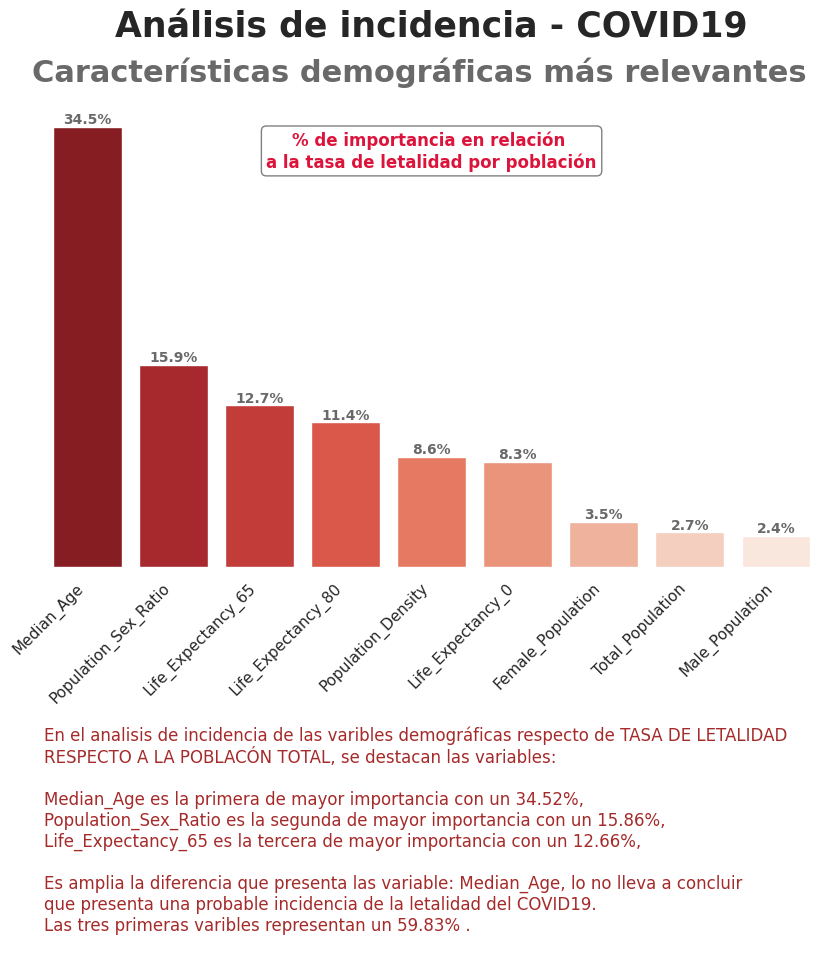

In [358]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_importances_02.index, y=feature_importances_02, palette='Reds_r', ax=ax,legend=False)

# Agrega valores al final de cada barra
for i, v in enumerate(feature_importances_02):
    ax.text(i, v, f'{v:.1%}', ha='center', va='bottom', fontsize=10, color='dimgray',fontweight='bold')

ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Análisis de incidencia - COVID19', y=1.13, fontsize=25, fontweight='bold')
plt.annotate('% de importancia en relación \na la tasa de letalidad por población', xy=(0.5, 0.9),
             xycoords='axes fraction', ha='center', va='center',
             fontsize=12, fontweight='bold', color='crimson',
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='GRAY', facecolor='none'))
plt.suptitle('Características demográficas más relevantes',y=.96, fontsize=22, color='dimgray',fontweight='bold')

plt.box(None)

plt.annotate(f'''
En el analisis de incidencia de las varibles demográficas respecto de TASA DE LETALIDAD
RESPECTO A LA POBLACÓN TOTAL, se destacan las variables:

{df_feature_importances_02['variable'][0]} es la primera de mayor importancia con un {df_feature_importances_02['valor'][0]:.2%},
{df_feature_importances_02['variable'][1]} es la segunda de mayor importancia con un {df_feature_importances_02['valor'][1]:.2%},
{df_feature_importances_02['variable'][2]} es la tercera de mayor importancia con un {df_feature_importances_02['valor'][2]:.2%},

Es amplia la diferencia que presenta las variable: {df_feature_importances_02['variable'][0]}, lo no lleva a concluir
que presenta una probable incidencia de la letalidad del COVID19.
Las tres primeras varibles representan un {df_feature_importances_02['valor'][0]+df_feature_importances_02['valor'][2]+df_feature_importances_02['valor'][2]:.2%} .
''',
             xy=(0, -0.3), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top',fontsize=12, color='brown')
plt.show()

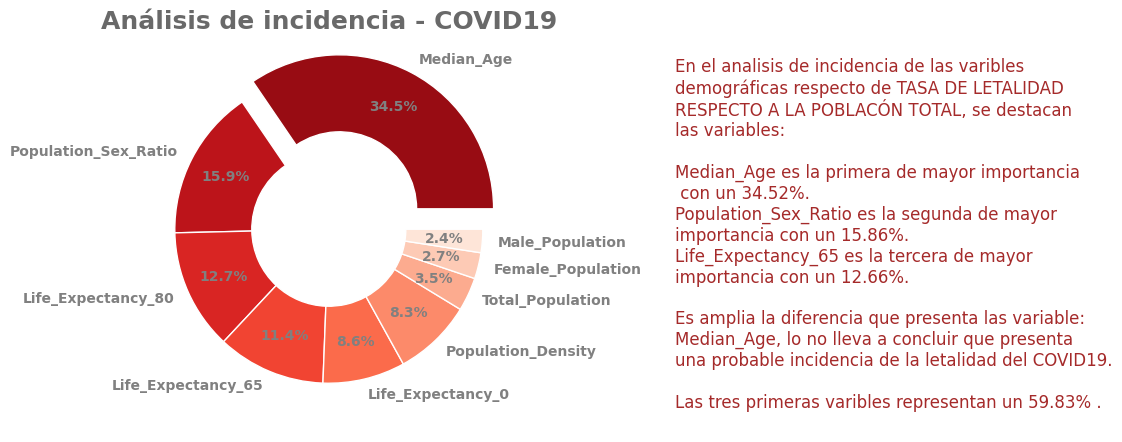

In [365]:
# Gráfico de Donuts
explode = (0.15,0,0,0,0,0,0,0,0)  # Explode solo la porción B
colors = sns.color_palette('Reds_r', len(df_feature_importances_02))

label_props = {'fontsize': 10,'color':'gray','fontweight':'bold'}
fig, axs = plt.subplots(figsize=(14, 5))
wedges, texts, autotexts = axs.pie(df_feature_importances_02.valor,explode=explode, autopct='%1.1f%%', textprops=label_props, pctdistance=0.75, startangle=0, wedgeprops=dict(width=0.5, edgecolor='w'),colors=colors,labels=df_feature_importances.variable)
axs.set_title(title, fontsize=18, color='dimgray', fontweight='bold')

plt.annotate(f'''
En el analisis de incidencia de las varibles
demográficas respecto de TASA DE LETALIDAD
RESPECTO A LA POBLACÓN TOTAL, se destacan
las variables:

{df_feature_importances_02['variable'][0]} es la primera de mayor importancia
 con un {df_feature_importances_02['valor'][0]:.2%}.
{df_feature_importances_02['variable'][1]} es la segunda de mayor
importancia con un {df_feature_importances_02['valor'][1]:.2%}.
{df_feature_importances_02['variable'][2]} es la tercera de mayor
importancia con un {df_feature_importances_02['valor'][2]:.2%}.

Es amplia la diferencia que presenta las variable:
{df_feature_importances_02['variable'][0]}, lo no lleva a concluir que presenta
una probable incidencia de la letalidad del COVID19.

Las tres primeras varibles representan un {df_feature_importances_02['valor'][0]+df_feature_importances_02['valor'][2]+df_feature_importances_02['valor'][2]:.2%} .
''',
             xy=(1.4, 1), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points',
             ha='left', va='top',fontsize=12, color='brown')
plt.show()